In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.metrics import roc_auc_score, f1_score, matthews_corrcoef, balanced_accuracy_score, r2_score , confusion_matrix, precision_score, recall_score

import pandas as pd
import numpy as np
import seaborn as sns

from my_util import *
from lime.lime.lime_tabular import LimeTabularExplainer

# from pyexplainer.pyexplainer_pyexplainer import PyExplainer
import matplotlib.pyplot as plt

import os, pickle, time, re, sys, operator
from datetime import datetime
from collections import Counter


sys.path.append(os.path.abspath('../pyexplainer'))
from pyexplainer_pyexplainer import *

from IPython.display import display

In [9]:
data_path = './dataset/'
result_dir = './eval_result/'
dump_dataframe_dir = './dump_df/'
pyExp_dir = './pyExplainer_obj/'
other_object_dir = './other_object/'
# proj_name = 'qt' # ['openstack','qt']

In [10]:
x_train,x_test,y_train ,y_test = prepare_data('openstack')
print(len(y_train),np.sum(y_train))
print(len(y_test),np.sum(y_test))

# display(x_train)
# display(x_test)

9246 980
3963 646


In [11]:
op_py_exp = pickle.load(open(pyExp_dir+'openstack'+'_rulefit_crossoverinterpolation_'+'1e6973aee7137653c62dcef970b1e2527b50517d'+'.pkl','rb'))
# lime_exp = pickle.load(open(pyExp_dir+'openstack'+'_lime_'+row_index+'.pkl','rb'))
qt_py_exp = pickle.load(open(pyExp_dir+'qt'+'_rulefit_crossoverinterpolation_'+'f5dbc876378ae58a7bdfe1e9664fc81caca18dfb'+'.pkl','rb'))

print(op_py_exp.keys())
print(np.sum(op_py_exp['synthetic_predictions'])/len(op_py_exp['synthetic_predictions']))
print(np.sum(qt_py_exp['synthetic_predictions'])/len(qt_py_exp['synthetic_predictions']))

dict_keys(['synthetic_data', 'synthetic_predictions', 'X_explain', 'y_explain', 'indep', 'dep', 'top_k_positive_rules', 'top_k_negative_rules', 'commit_id', 'local_model'])
0.45803571428571427
0.43824336688014637


In [12]:
# def test_lime(proj_name):
#     global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name)
#     all_eval_result = pd.DataFrame()
    
#     for i in range(0,len(feature_df)):
#         X_explain = feature_df.iloc[[i]]

#         row_index = str(X_explain.index[0])

#         py_exp = pickle.load(open(pyExp_dir+proj_name+'_rulefit_crossoverinterpolation_'+row_index+'.pkl','rb'))
#         lime_exp = pickle.load(open(pyExp_dir+proj_name+'_lime_'+row_index+'.pkl','rb'))

#         # this data can be used for both local and global model
#         py_exp_synthetic_data = py_exp['synthetic_data'].values
#         # this data can be used with global model only
#         lime_exp_synthetic_data = lime_exp['synthetic_instance_for_global_model']
#         # this data can be used with local model only
#         lime_exp_synthetic_data_local = lime_exp['synthetic_instance_for_lobal_model']
        
#         display(X_explain)
#         display(lime_exp_synthetic_data[:5,:])
#         display(lime_exp_synthetic_data_local[:5,:])
        
#         break
        
# test_lime('openstack')

In [13]:
flip_sign_dict = {
    '<': '>=',
    '>': '<=',
    '=': '!=',
    '>=': '<',
    '<=': '>',
    '!=': '=='
}

'''
    input: rule (str)
'''
def flip_rule(rule):
    rule = re.sub(r'\b=\b',' = ',rule) # for LIME
#     rule = rule.replace('&','and') # for RuleFit
    found_rule = re.findall('.* <=? [a-zA-Z]+ <=? .*', rule) # for LIME
    ret = ''
    
    # for LIME that has condition like this: 0.53 < nref <= 0.83
    if len(found_rule) > 0:
        found_rule = found_rule[0]
    
        var_in_rule = re.findall('[a-zA-Z]+',found_rule)

        var_in_rule = var_in_rule[0]
        
        splitted_rule = found_rule.split(var_in_rule)
        splitted_rule[0] = splitted_rule[0] + var_in_rule # for left side
        splitted_rule[1] = var_in_rule + splitted_rule[1] # for right side
        combined_rule = splitted_rule[0] + ' or ' + splitted_rule[1]
        ret = flip_rule(combined_rule)
        
    else:
        for tok in rule.split():
            if tok in flip_sign_dict:
                ret = ret + flip_sign_dict[tok] + ' '
            else:
                ret = ret + tok + ' '
    return ret

def get_top_k_global_features(global_model, indep, top_k_global_feature_num = 5):
    global_feature_df = pd.DataFrame()
    global_feature_df['feature'] = indep
    global_feature_df['importance'] = global_model.feature_importances_

    global_feature_df = global_feature_df.sort_values(by='importance',ascending=False)

    top_k_global_features = list(global_feature_df['feature'])[:top_k_global_feature_num]

    return top_k_global_features
    
def sort_global_feature(global_model, indep):
    global_feature_df = pd.DataFrame()
    global_feature_df['feature'] = indep
    global_feature_df['importance'] = global_model.feature_importances_

    global_feature_df = global_feature_df.sort_values(by='importance',ascending=False)

    sorted_global_features = list(global_feature_df['feature'])

    return sorted_global_features

def get_rule_str_of_rulefit(local_rulefit_model):
    rule_df = local_rulefit_model.get_rules()
#     print(rule_df)
    top_k = 5
    top_k_positive_rules = rule_df[(rule_df.coef > 0) & (rule_df.type=='rule')].sort_values("importance", ascending=False).head(top_k)
#     top_k_positive_rules = rule_df[(rule_df.coef > 0) & (rule_df.type=='rule')].sort_values("coef", ascending=False).head(top_k)

    the_best_defective_rule_str = list(top_k_positive_rules['rule'])[0]
    
    return the_best_defective_rule_str

def get_rule_str_of_rulefit_new_version(local_rulefit_model):
    rule_df = local_rulefit_model.get_rules()
    rule_df =  rule_df[(rule_df.coef > 0) & (rule_df.type=='rule')].sort_values("importance", ascending=False)
    
    rule_list = list(rule_df['rule'])
    dup_feature_in_rule = [] # true or false...
    
    for r in rule_list:
        var_in_rule = re.findall('[a-zA-Z]+', r)
        var_count = Counter(var_in_rule)
        max_count = max(list(var_count.values()))
        
        if max_count > 1:
            dup_feature_in_rule.append(True)
        else:
            dup_feature_in_rule.append(False)
           
    if False not in set(dup_feature_in_rule):
#         print('wtf')
        rule_df = rule_df.head(5)
        the_best_defective_rule_str = list(rule_df['rule'])[0]
        
    else:
        rule_df['contain_dup_var'] = dup_feature_in_rule    
        the_best_defective_rule_str = rule_df[rule_df['contain_dup_var']==False].iloc[0]['rule']
    
    return the_best_defective_rule_str

def aggregate_list(l):
    return np.mean(l), np.median(l)


In [14]:
# def test_new_rule_from_rulefit(proj_name):
#     global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name)
#     all_eval_result = pd.DataFrame()
    
#     c = 0
    
# #     py_exp_all_rules = []
# #     lime_all_rules = []
#     py_exp_all_vars = []
#     lime_all_vars = []
    
#     print('global feature feature importance ranking:')
#     print(sort_global_feature(global_model, indep))
#     for i in range(0,len(feature_df)):
#         X_explain = feature_df.iloc[[i]]

#         row_index = str(X_explain.index[0])

#         py_exp = pickle.load(open(pyExp_dir+proj_name+'_rulefit_crossoverinterpolation_'+row_index+'_20_rules.pkl','rb'))
#         py_exp_local_model = py_exp['local_model']
        
#         lime_exp = pickle.load(open(pyExp_dir+proj_name+'_lime_'+row_index+'.pkl','rb'))
        
# #         py_exp_rule = get_rule_str_of_rulefit(py_exp_local_model)
#         py_exp_rule_new = get_rule_str_of_rulefit_new_version(py_exp_local_model)
#         lime_the_best_defective_rule_str = lime_exp['rule'].as_list()[0][0]

#         py_exp_pred = eval_rule(py_exp_rule_new, X_explain)[0]
#         lime_pred = eval_rule(lime_the_best_defective_rule_str, X_explain)[0]

#         if py_exp_pred == 1:
#             py_exp_var_in_rule = list(set(re.findall('[a-zA-Z]+', py_exp_rule_new)))
#             py_exp_all_vars.extend(py_exp_var_in_rule)
#         if lime_pred == 1:
#             lime_var_in_rule = list(set(re.findall('[a-zA-Z]+', lime_the_best_defective_rule_str)))
#             lime_all_vars.extend(lime_var_in_rule)
            
# #         py_exp_all_rules.append(py_exp_rule_new)
# #         lime_all_rules.append(lime_the_best_defective_rule_str)
        
# #         eval_result = eval_rule(lime_the_best_defective_rule_str, X_explain)

# #         if eval_result[0]:
# #             c =c+1

    
# #     print(len(set(py_exp_all_rules)))
# #     print(len(set(lime_all_rules)))
    
#     print('pyExplainer var count')
#     print(Counter(py_exp_all_vars))
#     print('-'*100)
#     print('LIME var count')
#     print(Counter(lime_all_vars))
    
# print('openstack')
# test_new_rule_from_rulefit('openstack')
# print('*'*100)
# print('qt')
# test_new_rule_from_rulefit('qt')

In [15]:
def is_in_top_k_global_features(top_k_global_features, the_best_defective_rule_str):
    # remove numeric value
    new_the_best_defective_rule_str = re.sub('\d+','', the_best_defective_rule_str)

    # remove special characters
    new_the_best_defective_rule_str = re.sub('\W+',' ',new_the_best_defective_rule_str)
    splitted_rule = new_the_best_defective_rule_str.split()

    local_feature_count = 0
    
    found_features = set(splitted_rule).intersection(top_k_global_features)
    return list(found_features)

# def eval_rule(rule, X_explain):
#     var_in_rule = re.findall('[a-zA-Z]+',rule)
#     rule = rule.replace('&','and') # just for rulefit
#     rule = re.sub(r'\b=\b','==',rule)
# #             rule = rule.replace('=','==')

#     var_dict = {}

#     for var in var_in_rule:
#         var_dict[var] = float(X_explain[var])

#     eval_result = eval(rule,var_dict)
#     return eval_result

        
def prepare_data_for_testing(proj_name):
    global_model = pickle.load(open(proj_name+'_global_model.pkl','rb'))

    correctly_predict_df = pd.read_csv(dump_dataframe_dir+proj_name+'_correctly_predict_as_defective.csv')
    correctly_predict_df = correctly_predict_df.set_index('commit_id')

    dep = 'defect'
    indep = correctly_predict_df.columns[:-3] # exclude the last 3 columns

    feature_df = correctly_predict_df.loc[:, indep]
    
    return global_model, correctly_predict_df, indep, dep, feature_df
    

# RQ1 evaluation

In [98]:
def check_LIME_generated_instances(proj_name):
    global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name)
    all_eval_result = pd.DataFrame()
    
    for i in range(0,len(feature_df)):
        X_explain = feature_df.iloc[[i]]

        row_index = str(X_explain.index[0])
        lime_exp = pickle.load(open(pyExp_dir+proj_name+'_lime_'+row_index+'.pkl','rb'))

        # this data can be used with global model only
        lime_exp_synthetic_data = lime_exp['synthetic_instance_for_global_model']
        
        lime_exp_local_model = lime_exp['local_model']


        lime_exp_global_pred = global_model.predict(lime_exp_synthetic_data)
#         lime_exp_local_pred = np.round(lime_exp_local_pred)

        total_defect =  np.sum(lime_exp_global_pred)
        total_inst = len(lime_exp_global_pred)
        lime_exp_def_pred_ratio = total_defect/total_inst

        print(total_defect, total_inst, lime_exp_def_pred_ratio)
#         print(np.sum(py_exp_global_pred), len(py_exp_global_pred), np.sum(lime_exp_global_pred), len(lime_exp_global_pred))
#         py_exp_serie = pd.Series(data=[proj_name, row_index, 'pyExplainer',
#                                        py_exp_dist_med, py_exp_def_pred_ratio])
#         lime_exp_serie = pd.Series(data=[proj_name, row_index, 'LIME',
#                                          lime_exp_dist_med, lime_exp_def_pred_ratio])
        
#         all_eval_result = all_eval_result.append(py_exp_serie,ignore_index=True)
#         all_eval_result = all_eval_result.append(lime_exp_serie, ignore_index=True)

In [99]:
# check_LIME_generated_instances('openstack')

820 5000 0.164
839 5000 0.1678
829 5000 0.1658
872 5000 0.1744
853 5000 0.1706
810 5000 0.162
840 5000 0.168
866 5000 0.1732
809 5000 0.1618
837 5000 0.1674
841 5000 0.1682
800 5000 0.16
831 5000 0.1662
808 5000 0.1616
820 5000 0.164
822 5000 0.1644
851 5000 0.1702
824 5000 0.1648
829 5000 0.1658
821 5000 0.1642
783 5000 0.1566
839 5000 0.1678
862 5000 0.1724
803 5000 0.1606


KeyboardInterrupt: 

In [100]:
# check_LIME_generated_instances('qt')

660 5000 0.132
667 5000 0.1334
681 5000 0.1362
646 5000 0.1292
695 5000 0.139
698 5000 0.1396
673 5000 0.1346
649 5000 0.1298
691 5000 0.1382
688 5000 0.1376
697 5000 0.1394
714 5000 0.1428
638 5000 0.1276
663 5000 0.1326
687 5000 0.1374
651 5000 0.1302
681 5000 0.1362
615 5000 0.123
678 5000 0.1356
670 5000 0.134
679 5000 0.1358
724 5000 0.1448
697 5000 0.1394
714 5000 0.1428


KeyboardInterrupt: 

In [11]:
def rq1_eval(proj_name):
    global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name)
    all_eval_result = pd.DataFrame()
    
    for i in range(0,len(feature_df)):
        X_explain = feature_df.iloc[[i]]

        row_index = str(X_explain.index[0])

        py_exp = pickle.load(open(pyExp_dir+proj_name+'_rulefit_crossoverinterpolation_'+row_index+'.pkl','rb'))
        lime_exp = pickle.load(open(pyExp_dir+proj_name+'_lime_'+row_index+'.pkl','rb'))

        # this data can be used for both local and global model
        py_exp_synthetic_data = py_exp['synthetic_data'].values
        # this data can be used with global model only
        lime_exp_synthetic_data = lime_exp['synthetic_instance_for_global_model']
        
        py_exp_local_model = py_exp['local_model']
        lime_exp_local_model = lime_exp['local_model']

        py_exp_global_pred = global_model.predict(py_exp_synthetic_data)

        lime_exp_global_pred = global_model.predict(lime_exp_synthetic_data)
#         lime_exp_local_pred = np.round(lime_exp_local_pred)

        py_exp_dist = euclidean_distances(X_explain.values, py_exp_synthetic_data)
        lime_dist = euclidean_distances(X_explain.values, lime_exp_synthetic_data)

        py_exp_dist_mean, py_exp_dist_med = aggregate_list(py_exp_dist)
        lime_exp_dist_mean, lime_exp_dist_med = aggregate_list(lime_dist)

        py_exp_def_pred_ratio = np.sum(py_exp_global_pred)/len(py_exp_global_pred)
        lime_exp_def_pred_ratio = np.sum(lime_exp_global_pred)/len(lime_exp_global_pred)

#         print(np.sum(py_exp_global_pred), len(py_exp_global_pred), np.sum(lime_exp_global_pred), len(lime_exp_global_pred))
        py_exp_serie = pd.Series(data=[proj_name, row_index, 'pyExplainer',
                                       py_exp_dist_med, py_exp_def_pred_ratio])
        lime_exp_serie = pd.Series(data=[proj_name, row_index, 'LIME',
                                         lime_exp_dist_med, lime_exp_def_pred_ratio])
        
        all_eval_result = all_eval_result.append(py_exp_serie,ignore_index=True)
        all_eval_result = all_eval_result.append(lime_exp_serie, ignore_index=True)
        
#         print(py_exp_def_pred_ratio, lime_exp_def_pred_ratio)
#         break
    all_eval_result.columns =['project', 'commit id', 'method', 'euc_dist_med', 'defective_generated_instance_ratio']
    
# # #     display(all_eval_result)
    all_eval_result.to_csv(result_dir+'RQ1_'+proj_name+'.csv',index=False)
    print('finished RQ1 of',proj_name)
    
# rq1_eval('openstack') 

In [12]:
rq1_eval('openstack')
print('-'*100)
rq1_eval('qt')

finished RQ1 of openstack
----------------------------------------------------------------------------------------------------
finished RQ1 of qt


,project,commit id,method,euc_dist_med,defective_generated_instance_ratio
0,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,pyExplainer,347.227417,0.458036
1,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,LIME,547.648247,0.164000
2,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,pyExplainer,513.468857,0.717350
3,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,LIME,1384.777800,0.167800
4,openstack,de31210c05f464c4a79255de68b1a515d9b84ed3,pyExplainer,235.933907,0.528571


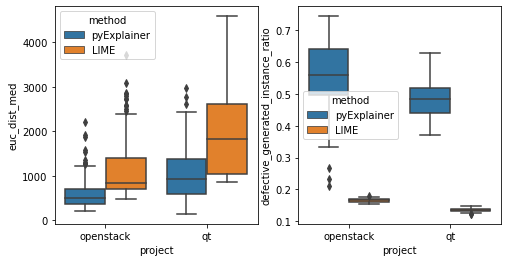

euc_dist_med                                       \
                             count         mean         std         min   
project   method                                                          
openstack LIME               198.0  1126.993520  623.744796  478.122694   
          pyExplainer        198.0   592.070320  337.191524  207.942660   
qt        LIME                79.0  1979.342782  993.311405  856.917999   
          pyExplainer         79.0  1075.298756  660.440093  144.160726   

                                                                           \
                               25%          50%          75%          max   
project   method                                                            
openstack LIME          707.911839   839.004043  1406.863950  3714.300936   
          pyExplainer   360.140600   492.263210   711.340966  2211.919036   
qt        LIME         1039.673910  1824.515489  2602.748286  4582.471964   
          pyExplainer   583.951160   928.180997  1376.656518  2972.962739   

                      defective_generated_instance_ratio                      \
                                                   count      mean       std   
project   method                                                               
openstack LIME                                     198.0  0.165280  0.004570   
          pyExplainer                              198.0  0.560862  0.094688   
qt        LIME                                      79.0  0.135856  0.004667   
          pyExplainer                               79.0  0.484406  0.057689   

                                                                         
                            min       25%       50%       75%       max  
project   method                                                         
openstack LIME         0.154600  0.161850  0.165200  0.168400  0.180800  
          pyExplainer  0.209821  0.496094  0.558500  0.640781  0.743723  
qt        LIME         0.123000  0.133100  0.136200  0.139000  0.147400  
          pyExplainer  0.371429  0.441071  0.483511  0.517834  0.628449

In [13]:
openstack_result_df = pd.read_csv('./eval_result/RQ1_openstack.csv')
qt_result_df = pd.read_csv('./eval_result/RQ1_qt.csv')

result_df = pd.concat([openstack_result_df, qt_result_df])
display(result_df.head())

fig, axs = plt.subplots(1,2, figsize=(8,4))

sns.boxplot(data=result_df, x='project', y='euc_dist_med', hue='method', ax=axs[0])
sns.boxplot(data=result_df, x='project', y='defective_generated_instance_ratio', hue='method', ax=axs[1])
plt.show()

display(result_df.groupby(['project', 'method']).describe())

# RQ2 evaluation

In [109]:
def check_pyExp_prediction(proj_name):
    global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name)
    all_eval_result = pd.DataFrame()

    for i in range(0,len(feature_df)):
        X_explain = feature_df.iloc[[i]]

        row_index = str(X_explain.index[0])

        py_exp = pickle.load(open(pyExp_dir+proj_name+'_rulefit_crossoverinterpolation_'+row_index+'.pkl','rb'))
        # this data can be used for both local and global model
        py_exp_synthetic_data = py_exp['synthetic_data'].values
        py_exp_local_model = py_exp['local_model']
        py_exp_global_pred = global_model.predict(py_exp_synthetic_data) 
        py_exp_local_prob = py_exp_local_model.predict_proba(py_exp_synthetic_data)[:,1]
        py_exp_local_pred = py_exp_local_model.predict(py_exp_synthetic_data)
        
        tn, fp, fn, tp = confusion_matrix(py_exp_global_pred, py_exp_local_pred).ravel()
        
        print('total prediction:',len(py_exp_global_pred))
        print('TN:',tn,'FP:', fp,'FN:', fn,'TP:', tp)
#         py_exp_local_pred = [1 if val else 0 for val in py_exp_local_pred]

#         pred_df = pd.DataFrame()
#         pred_df['label'] = py_exp_global_pred
#         pred_df['prob'] = py_exp_local_prob
#         pred_df['pred'] = py_exp_local_pred
        
#         true_pred_df = pred_df[pred_df['label']==True]
#         print('total prediction:',len(pred_df))
#         print('total global correct prediction:', len(true_pred_df))
#         display(true_pred_df)
        
        print('-'*100)
        
        if i > 10:
            break
#         py_exp_auc = roc_auc_score(py_exp_global_pred, py_exp_local_prob)
#         py_exp_f1 = f1_score(py_exp_global_pred, py_exp_local_pred)
#         py_exp_mcc = matthews_corrcoef(py_exp_global_pred, py_exp_local_pred)
#         py_exp_bal_acc = balanced_accuracy_score(py_exp_global_pred, py_exp_local_pred)
        
        
    

In [110]:
check_pyExp_prediction('openstack')

total prediction: 2240
TN: 1166 FP: 48 FN: 70 TP: 956
----------------------------------------------------------------------------------------------------
total prediction: 2098
TN: 578 FP: 15 FN: 3 TP: 1502
----------------------------------------------------------------------------------------------------
total prediction: 2240
TN: 1005 FP: 51 FN: 73 TP: 1111
----------------------------------------------------------------------------------------------------
total prediction: 2213
TN: 987 FP: 76 FN: 51 TP: 1099
----------------------------------------------------------------------------------------------------
total prediction: 2124
TN: 760 FP: 41 FN: 22 TP: 1301
----------------------------------------------------------------------------------------------------
total prediction: 2189
TN: 788 FP: 71 FN: 60 TP: 1270
----------------------------------------------------------------------------------------------------
total prediction: 2217
TN: 916 FP: 19 FN: 18 TP: 1264
----------------

In [111]:
check_pyExp_prediction('qt')

total prediction: 2186
TN: 1204 FP: 24 FN: 22 TP: 936
----------------------------------------------------------------------------------------------------
total prediction: 2240
TN: 1127 FP: 20 FN: 21 TP: 1072
----------------------------------------------------------------------------------------------------
total prediction: 2207
TN: 1190 FP: 17 FN: 16 TP: 984
----------------------------------------------------------------------------------------------------
total prediction: 2152
TN: 1041 FP: 27 FN: 18 TP: 1066
----------------------------------------------------------------------------------------------------
total prediction: 2092
TN: 797 FP: 48 FN: 38 TP: 1209
----------------------------------------------------------------------------------------------------
total prediction: 2193
TN: 1078 FP: 17 FN: 15 TP: 1083
----------------------------------------------------------------------------------------------------
total prediction: 2240
TN: 1127 FP: 16 FN: 22 TP: 1075
------------

In [16]:
def rq2_1_eval(proj_name):
    global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name)
    all_eval_result = pd.DataFrame()

    for i in range(0,len(feature_df)):
        X_explain = feature_df.iloc[[i]]

        row_index = str(X_explain.index[0])

        py_exp = pickle.load(open(pyExp_dir+proj_name+'_rulefit_crossoverinterpolation_'+row_index+'.pkl','rb'))
        lime_exp = pickle.load(open(pyExp_dir+proj_name+'_lime_'+row_index+'.pkl','rb'))

        # this data can be used for both local and global model
        py_exp_synthetic_data = py_exp['synthetic_data'].values
        # this data can be used with global model only
        lime_exp_synthetic_data = lime_exp['synthetic_instance_for_global_model']
        # this data can be used with local model only
        lime_exp_synthetic_data_local = lime_exp['synthetic_instance_for_lobal_model']
        
        py_exp_local_model = py_exp['local_model']
        lime_exp_local_model = lime_exp['local_model']

        py_exp_global_pred = global_model.predict(py_exp_synthetic_data) 
        py_exp_local_prob = py_exp_local_model.predict_proba(py_exp_synthetic_data)[:,1]
        py_exp_local_pred = py_exp_local_model.predict(py_exp_synthetic_data)
#         py_exp_local_pred = [1 if val else 0 for val in py_exp_local_pred]

        lime_exp_global_pred = global_model.predict(lime_exp_synthetic_data)
        lime_exp_local_prob = lime_exp_local_model.predict(lime_exp_synthetic_data_local)
        lime_exp_local_pred = np.round(lime_exp_local_prob)
        
        py_exp_auc = roc_auc_score(py_exp_global_pred, py_exp_local_prob)
        py_exp_f1 = f1_score(py_exp_global_pred, py_exp_local_pred)
        py_exp_mcc = matthews_corrcoef(py_exp_global_pred, py_exp_local_pred)
        py_exp_bal_acc = balanced_accuracy_score(py_exp_global_pred, py_exp_local_pred)
        
        lime_auc = roc_auc_score(lime_exp_global_pred, lime_exp_local_prob)
        lime_f1 = f1_score(lime_exp_global_pred, lime_exp_local_pred)
        lime_mcc = matthews_corrcoef(lime_exp_global_pred, lime_exp_local_pred)
        lime_bal_acc = balanced_accuracy_score(lime_exp_global_pred, lime_exp_local_pred)

        py_exp_serie = pd.Series(data=[proj_name, row_index, 'pyExplainer',
                                       py_exp_bal_acc, py_exp_auc, py_exp_f1, py_exp_mcc])
        lime_exp_serie = pd.Series(data=[proj_name, row_index, 'LIME',
                                          lime_bal_acc, lime_auc, lime_f1, lime_mcc])
        
        all_eval_result = all_eval_result.append(py_exp_serie,ignore_index=True)
        all_eval_result = all_eval_result.append(lime_exp_serie, ignore_index=True)
        
#         break

    all_eval_result.columns = ['project', 'commit id', 'method', 'balanced_accuracy', 'AUC', 'F1','MCC']

#     display(all_eval_result)
    all_eval_result.to_csv(result_dir+'RQ2_'+proj_name+'_global_vs_local_synt_pred.csv',index=False)
    print('finished RQ2 of',proj_name)

In [17]:
rq2_1_eval('openstack')
rq2_1_eval('qt')

/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalar

finished RQ2 of openstack


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


finished RQ2 of qt


,project,commit id,method,balanced_accuracy,AUC,F1,MCC
0,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,pyExplainer,0.946118,0.986281,0.941872,0.893895
1,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,LIME,0.579753,0.740423,0.281192,0.268961
2,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,pyExplainer,0.986356,0.999151,0.994044,0.978811
3,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,LIME,0.580125,0.745687,0.282288,0.277408
4,openstack,de31210c05f464c4a79255de68b1a515d9b84ed3,pyExplainer,0.945025,0.987775,0.947144,0.889220


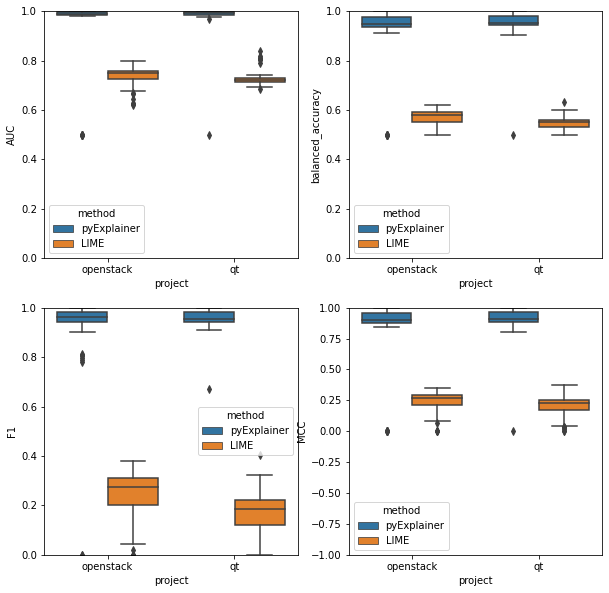

openstack result


balanced_accuracy                                               \
                        count      mean       std  min       25%       50%   
method                                                                       
LIME                    198.0  0.570394  0.027628  0.5  0.552933  0.578235   
pyExplainer             198.0  0.939229  0.092842  0.5  0.936735  0.949374   

                                   AUC                                \
                  75%       max  count      mean       std       min   
method                                                                 
LIME         0.591473  0.618989  198.0  0.739656  0.030157  0.620103   
pyExplainer  0.978000  1.000000  198.0  0.971823  0.097254  0.500000   

                                                        F1            \
                  25%       50%       75%       max  count      mean   
method                                                                 
LIME         0.723966  0.749075  0.759501  0.796816  198.0  0.248266   
pyExplainer  0.985531  0.989415  0.997699  1.000000  198.0  0.948083   

                                                                      MCC  \
                  std  min       25%       50%       75%       max  count   
method                                                                      
LIME         0.086481  0.0  0.202650  0.276290  0.311654  0.378698  198.0   
pyExplainer  0.102474  0.0  0.942779  0.960458  0.983025  1.000000  198.0   

                                                                              
                 mean       std  min       25%       50%       75%       max  
method                                                                        
LIME         0.248051  0.067190  0.0  0.211879  0.266913  0.296950  0.352627  
pyExplainer  0.880779  0.186045  0.0  0.874498  0.898087  0.957091  1.000000

qt result


balanced_accuracy                                               \
                        count      mean       std  min       25%       50%   
method                                                                       
LIME                     79.0  0.546394  0.026677  0.5  0.530102  0.549680   
pyExplainer              79.0  0.953690  0.055977  0.5  0.942347  0.952367   

                                  AUC                                          \
                  75%       max count      mean       std       min       25%   
method                                                                          
LIME         0.560867  0.633993  79.0  0.727975  0.030612  0.683462  0.712038   
pyExplainer  0.981322  1.000000  79.0  0.985522  0.055693  0.500000  0.986339   

                                            F1                                \
                  50%       75%      max count      mean       std       min   
method                                                                         
LIME         0.721298  0.729712  0.83789  79.0  0.169261  0.087309  0.000000   
pyExplainer  0.990802  0.998186  1.00000  79.0  0.954851  0.039663  0.671412   

                                                     MCC                      \
                  25%       50%       75%      max count      mean       std   
method                                                                         
LIME         0.120996  0.186503  0.220287  0.40197  79.0  0.200580  0.084425   
pyExplainer  0.940280  0.952612  0.981165  1.00000  79.0  0.908172  0.111955   

                                                        
             min       25%       50%       75%     max  
method                                                  
LIME         0.0  0.168595  0.228000  0.255264  0.3734  
pyExplainer  0.0  0.886572  0.905347  0.963109  1.0000

In [18]:
openstack_result_df = pd.read_csv('./eval_result/RQ2_openstack_global_vs_local_synt_pred.csv')
qt_result_df = pd.read_csv('./eval_result/RQ2_qt_global_vs_local_synt_pred.csv')

result_df = pd.concat([openstack_result_df, qt_result_df])
display(result_df.head())

fig, axs = plt.subplots(2,2, figsize=(10,10))

axs[0,0].set_ylim([0, 1])
axs[0,1].set_ylim([0, 1]) 
axs[1,0].set_ylim([0, 1]) 
sns.boxplot(data=result_df, x='project', y='AUC', hue='method', ax=axs[0,0])
sns.boxplot(data=result_df, x='project', y='balanced_accuracy', hue='method', ax=axs[0,1])
sns.boxplot(data=result_df, x='project', y='F1', hue='method', ax=axs[1,0])

plt.ylim(-1,1)
sns.boxplot(data=result_df, x='project', y='MCC', hue='method', ax=axs[1,1])

plt.show()

pd.set_option("max_columns", 40)
print('openstack result')
display(openstack_result_df.groupby('method').describe())
print('qt result')
display(qt_result_df.groupby('method').describe())

In [23]:
# roc_auc_score

# f1_score

# balanced_accuracy_score

# precision_score

# recall_score

def classification_eval(prob, pred, label):
    auc = roc_auc_score(label,prob)
    f1 = f1_score(label,pred)
    bal_acc = balanced_accuracy_score(label,pred)
    prec = precision_score(label,pred)
    rec = recall_score(label,pred)
    
    return auc, bal_acc, prec, rec, f1

def rq2_2_eval(proj_name):
    global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name)
    x_train, x_test, y_train, y_test = prepare_data(proj_name, mode = 'all')
    
#     ground_truth = np.ones(len(feature_df)).astype(bool)
    
    categorical_features_list = [6]
    
    class_label = ['clean', 'defect']
    
#     lime_explainer = LimeTabularExplainer(x_train.values, categorical_features=categorical_features_list, 
#                                       feature_names=indep, class_names=class_label,
#                                       random_state=0)

    
    py_exp_prob, py_exp_pred = [], []
    lime_prob, lime_pred = [], []
    
    local_pred_df = pd.DataFrame()
    
    for i in range(0,len(x_test)):
        X_explain = x_test.iloc[[i]]

        row_index = str(X_explain.index[0])

        exp_obj = pickle.load(open(pyExp_dir+proj_name+'_all_explainer_'+row_index+'.pkl','rb'))
#         print(exp_obj.keys())
        py_exp = exp_obj['pyExplainer']
        lime_exp = exp_obj['LIME']

        py_exp_local_model = py_exp['local_model']
        lime_exp_local_model = lime_exp['local_model']
        
        selected_feature_indices = lime_exp['selected_feature_indeces']
        lime_input = np.ones((1,len(selected_feature_indices)))

        py_exp_local_prob = py_exp_local_model.predict_proba(X_explain.values)[:,1][0]
        py_exp_local_pred = py_exp_local_model.predict(X_explain.values)[0]

        lime_exp_local_prob = lime_exp_local_model.predict(lime_input)[0]
        lime_exp_local_pred = np.round(lime_exp_local_prob).astype(bool)

#         print(py_exp_local_prob, py_exp_local_pred, lime_exp_local_prob, lime_exp_local_pred)
#         print('predict finished')
        
        py_exp_prob.append(py_exp_local_prob)
        py_exp_pred.append(py_exp_local_pred)
        
        
        lime_prob.append(lime_exp_local_prob)
        lime_pred.append(lime_exp_local_pred)
#         print(py_exp_local_prob, py_exp_local_pred, lime_exp_local_prob, lime_exp_local_pred)
#         print(py_exp_pred, lime_pred)
        
#         if py_exp_pred == 1:
#             py_exp_pred_count = py_exp_pred_count +1
#         if lime_pred == 1:
#             lime_pred_count = lime_pred_count + 1

#         del py_exp, lime_exp, py_exp_local_model, lime_exp_local_model
#         print(py_exp_local_pred, lime_exp_local_pred)
        print('finished {}/{} instances'.format(i, len(x_test)))
#         break
  
    local_pred_df['ground_truth'] = list(y_test)
    local_pred_df['pyExplainer_prob'] = py_exp_prob
    local_pred_df['pyExplainer_pred'] = py_exp_pred
    local_pred_df['lime_prob'] = lime_prob
    local_pred_df['lime_pred'] = lime_pred
    
    local_pred_df.to_csv(dump_dataframe_dir+proj_name+'_local_prediction_of_actual_test_data.csv',index=False)
    
    print('pyExplainer')
    tn, fp, fn, tp = confusion_matrix(y_test, py_exp_pred).ravel()
    print(tn, fp, fn, tp)
    auc, bal_acc, prec, rec, f1 = classification_eval(py_exp_prob, py_exp_pred, y_test)
    print(bal_acc, prec, rec, f1)
    
    print('LIME')
    tn, fp, fn, tp = confusion_matrix(y_test, lime_pred).ravel()
    print(tn, fp, fn, tp)
    auc, bal_acc, prec, rec, f1 = classification_eval(lime_prob, lime_pred, y_test)
    print(bal_acc, prec, rec, f1)
    
    print('finished RQ555 of',proj_name)

In [24]:
start = time.time()
rq2_2_eval('openstack')
end = time.time()
print('time spent {} secs'.format(end-start))

finished 0/3963 instances
finished 1/3963 instances
finished 2/3963 instances
finished 3/3963 instances
finished 4/3963 instances
finished 5/3963 instances
finished 6/3963 instances
finished 7/3963 instances
finished 8/3963 instances
finished 9/3963 instances
finished 10/3963 instances
finished 11/3963 instances
finished 12/3963 instances
finished 13/3963 instances
finished 14/3963 instances
finished 15/3963 instances
finished 16/3963 instances
finished 17/3963 instances
finished 18/3963 instances
finished 19/3963 instances
finished 20/3963 instances
finished 21/3963 instances
finished 22/3963 instances
finished 23/3963 instances
finished 24/3963 instances
finished 25/3963 instances
finished 26/3963 instances
finished 27/3963 instances
finished 28/3963 instances
finished 29/3963 instances
finished 30/3963 instances
finished 31/3963 instances
finished 32/3963 instances
finished 33/3963 instances
finished 34/3963 instances
finished 35/3963 instances
finished 36/3963 instances
finished 37

finished 298/3963 instances
finished 299/3963 instances
finished 300/3963 instances
finished 301/3963 instances
finished 302/3963 instances
finished 303/3963 instances
finished 304/3963 instances
finished 305/3963 instances
finished 306/3963 instances
finished 307/3963 instances
finished 308/3963 instances
finished 309/3963 instances
finished 310/3963 instances
finished 311/3963 instances
finished 312/3963 instances
finished 313/3963 instances
finished 314/3963 instances
finished 315/3963 instances
finished 316/3963 instances
finished 317/3963 instances
finished 318/3963 instances
finished 319/3963 instances
finished 320/3963 instances
finished 321/3963 instances
finished 322/3963 instances
finished 323/3963 instances
finished 324/3963 instances
finished 325/3963 instances
finished 326/3963 instances
finished 327/3963 instances
finished 328/3963 instances
finished 329/3963 instances
finished 330/3963 instances
finished 331/3963 instances
finished 332/3963 instances
finished 333/3963 in

finished 591/3963 instances
finished 592/3963 instances
finished 593/3963 instances
finished 594/3963 instances
finished 595/3963 instances
finished 596/3963 instances
finished 597/3963 instances
finished 598/3963 instances
finished 599/3963 instances
finished 600/3963 instances
finished 601/3963 instances
finished 602/3963 instances
finished 603/3963 instances
finished 604/3963 instances
finished 605/3963 instances
finished 606/3963 instances
finished 607/3963 instances
finished 608/3963 instances
finished 609/3963 instances
finished 610/3963 instances
finished 611/3963 instances
finished 612/3963 instances
finished 613/3963 instances
finished 614/3963 instances
finished 615/3963 instances
finished 616/3963 instances
finished 617/3963 instances
finished 618/3963 instances
finished 619/3963 instances
finished 620/3963 instances
finished 621/3963 instances
finished 622/3963 instances
finished 623/3963 instances
finished 624/3963 instances
finished 625/3963 instances
finished 626/3963 in

finished 884/3963 instances
finished 885/3963 instances
finished 886/3963 instances
finished 887/3963 instances
finished 888/3963 instances
finished 889/3963 instances
finished 890/3963 instances
finished 891/3963 instances
finished 892/3963 instances
finished 893/3963 instances
finished 894/3963 instances
finished 895/3963 instances
finished 896/3963 instances
finished 897/3963 instances
finished 898/3963 instances
finished 899/3963 instances
finished 900/3963 instances
finished 901/3963 instances
finished 902/3963 instances
finished 903/3963 instances
finished 904/3963 instances
finished 905/3963 instances
finished 906/3963 instances
finished 907/3963 instances
finished 908/3963 instances
finished 909/3963 instances
finished 910/3963 instances
finished 911/3963 instances
finished 912/3963 instances
finished 913/3963 instances
finished 914/3963 instances
finished 915/3963 instances
finished 916/3963 instances
finished 917/3963 instances
finished 918/3963 instances
finished 919/3963 in

finished 1171/3963 instances
finished 1172/3963 instances
finished 1173/3963 instances
finished 1174/3963 instances
finished 1175/3963 instances
finished 1176/3963 instances
finished 1177/3963 instances
finished 1178/3963 instances
finished 1179/3963 instances
finished 1180/3963 instances
finished 1181/3963 instances
finished 1182/3963 instances
finished 1183/3963 instances
finished 1184/3963 instances
finished 1185/3963 instances
finished 1186/3963 instances
finished 1187/3963 instances
finished 1188/3963 instances
finished 1189/3963 instances
finished 1190/3963 instances
finished 1191/3963 instances
finished 1192/3963 instances
finished 1193/3963 instances
finished 1194/3963 instances
finished 1195/3963 instances
finished 1196/3963 instances
finished 1197/3963 instances
finished 1198/3963 instances
finished 1199/3963 instances
finished 1200/3963 instances
finished 1201/3963 instances
finished 1202/3963 instances
finished 1203/3963 instances
finished 1204/3963 instances
finished 1205/

finished 1456/3963 instances
finished 1457/3963 instances
finished 1458/3963 instances
finished 1459/3963 instances
finished 1460/3963 instances
finished 1461/3963 instances
finished 1462/3963 instances
finished 1463/3963 instances
finished 1464/3963 instances
finished 1465/3963 instances
finished 1466/3963 instances
finished 1467/3963 instances
finished 1468/3963 instances
finished 1469/3963 instances
finished 1470/3963 instances
finished 1471/3963 instances
finished 1472/3963 instances
finished 1473/3963 instances
finished 1474/3963 instances
finished 1475/3963 instances
finished 1476/3963 instances
finished 1477/3963 instances
finished 1478/3963 instances
finished 1479/3963 instances
finished 1480/3963 instances
finished 1481/3963 instances
finished 1482/3963 instances
finished 1483/3963 instances
finished 1484/3963 instances
finished 1485/3963 instances
finished 1486/3963 instances
finished 1487/3963 instances
finished 1488/3963 instances
finished 1489/3963 instances
finished 1490/

finished 1741/3963 instances
finished 1742/3963 instances
finished 1743/3963 instances
finished 1744/3963 instances
finished 1745/3963 instances
finished 1746/3963 instances
finished 1747/3963 instances
finished 1748/3963 instances
finished 1749/3963 instances
finished 1750/3963 instances
finished 1751/3963 instances
finished 1752/3963 instances
finished 1753/3963 instances
finished 1754/3963 instances
finished 1755/3963 instances
finished 1756/3963 instances
finished 1757/3963 instances
finished 1758/3963 instances
finished 1759/3963 instances
finished 1760/3963 instances
finished 1761/3963 instances
finished 1762/3963 instances
finished 1763/3963 instances
finished 1764/3963 instances
finished 1765/3963 instances
finished 1766/3963 instances
finished 1767/3963 instances
finished 1768/3963 instances
finished 1769/3963 instances
finished 1770/3963 instances
finished 1771/3963 instances
finished 1772/3963 instances
finished 1773/3963 instances
finished 1774/3963 instances
finished 1775/

finished 2025/3963 instances
finished 2026/3963 instances
finished 2027/3963 instances
finished 2028/3963 instances
finished 2029/3963 instances
finished 2030/3963 instances
finished 2031/3963 instances
finished 2032/3963 instances
finished 2033/3963 instances
finished 2034/3963 instances
finished 2035/3963 instances
finished 2036/3963 instances
finished 2037/3963 instances
finished 2038/3963 instances
finished 2039/3963 instances
finished 2040/3963 instances
finished 2041/3963 instances
finished 2042/3963 instances
finished 2043/3963 instances
finished 2044/3963 instances
finished 2045/3963 instances
finished 2046/3963 instances
finished 2047/3963 instances
finished 2048/3963 instances
finished 2049/3963 instances
finished 2050/3963 instances
finished 2051/3963 instances
finished 2052/3963 instances
finished 2053/3963 instances
finished 2054/3963 instances
finished 2055/3963 instances
finished 2056/3963 instances
finished 2057/3963 instances
finished 2058/3963 instances
finished 2059/

finished 2310/3963 instances
finished 2311/3963 instances
finished 2312/3963 instances
finished 2313/3963 instances
finished 2314/3963 instances
finished 2315/3963 instances
finished 2316/3963 instances
finished 2317/3963 instances
finished 2318/3963 instances
finished 2319/3963 instances
finished 2320/3963 instances
finished 2321/3963 instances
finished 2322/3963 instances
finished 2323/3963 instances
finished 2324/3963 instances
finished 2325/3963 instances
finished 2326/3963 instances
finished 2327/3963 instances
finished 2328/3963 instances
finished 2329/3963 instances
finished 2330/3963 instances
finished 2331/3963 instances
finished 2332/3963 instances
finished 2333/3963 instances
finished 2334/3963 instances
finished 2335/3963 instances
finished 2336/3963 instances
finished 2337/3963 instances
finished 2338/3963 instances
finished 2339/3963 instances
finished 2340/3963 instances
finished 2341/3963 instances
finished 2342/3963 instances
finished 2343/3963 instances
finished 2344/

finished 2595/3963 instances
finished 2596/3963 instances
finished 2597/3963 instances
finished 2598/3963 instances
finished 2599/3963 instances
finished 2600/3963 instances
finished 2601/3963 instances
finished 2602/3963 instances
finished 2603/3963 instances
finished 2604/3963 instances
finished 2605/3963 instances
finished 2606/3963 instances
finished 2607/3963 instances
finished 2608/3963 instances
finished 2609/3963 instances
finished 2610/3963 instances
finished 2611/3963 instances
finished 2612/3963 instances
finished 2613/3963 instances
finished 2614/3963 instances
finished 2615/3963 instances
finished 2616/3963 instances
finished 2617/3963 instances
finished 2618/3963 instances
finished 2619/3963 instances
finished 2620/3963 instances
finished 2621/3963 instances
finished 2622/3963 instances
finished 2623/3963 instances
finished 2624/3963 instances
finished 2625/3963 instances
finished 2626/3963 instances
finished 2627/3963 instances
finished 2628/3963 instances
finished 2629/

finished 2878/3963 instances
finished 2879/3963 instances
finished 2880/3963 instances
finished 2881/3963 instances
finished 2882/3963 instances
finished 2883/3963 instances
finished 2884/3963 instances
finished 2885/3963 instances
finished 2886/3963 instances
finished 2887/3963 instances
finished 2888/3963 instances
finished 2889/3963 instances
finished 2890/3963 instances
finished 2891/3963 instances
finished 2892/3963 instances
finished 2893/3963 instances
finished 2894/3963 instances
finished 2895/3963 instances
finished 2896/3963 instances
finished 2897/3963 instances
finished 2898/3963 instances
finished 2899/3963 instances
finished 2900/3963 instances
finished 2901/3963 instances
finished 2902/3963 instances
finished 2903/3963 instances
finished 2904/3963 instances
finished 2905/3963 instances
finished 2906/3963 instances
finished 2907/3963 instances
finished 2908/3963 instances
finished 2909/3963 instances
finished 2910/3963 instances
finished 2911/3963 instances
finished 2912/

finished 3161/3963 instances
finished 3162/3963 instances
finished 3163/3963 instances
finished 3164/3963 instances
finished 3165/3963 instances
finished 3166/3963 instances
finished 3167/3963 instances
finished 3168/3963 instances
finished 3169/3963 instances
finished 3170/3963 instances
finished 3171/3963 instances
finished 3172/3963 instances
finished 3173/3963 instances
finished 3174/3963 instances
finished 3175/3963 instances
finished 3176/3963 instances
finished 3177/3963 instances
finished 3178/3963 instances
finished 3179/3963 instances
finished 3180/3963 instances
finished 3181/3963 instances
finished 3182/3963 instances
finished 3183/3963 instances
finished 3184/3963 instances
finished 3185/3963 instances
finished 3186/3963 instances
finished 3187/3963 instances
finished 3188/3963 instances
finished 3189/3963 instances
finished 3190/3963 instances
finished 3191/3963 instances
finished 3192/3963 instances
finished 3193/3963 instances
finished 3194/3963 instances
finished 3195/

finished 3444/3963 instances
finished 3445/3963 instances
finished 3446/3963 instances
finished 3447/3963 instances
finished 3448/3963 instances
finished 3449/3963 instances
finished 3450/3963 instances
finished 3451/3963 instances
finished 3452/3963 instances
finished 3453/3963 instances
finished 3454/3963 instances
finished 3455/3963 instances
finished 3456/3963 instances
finished 3457/3963 instances
finished 3458/3963 instances
finished 3459/3963 instances
finished 3460/3963 instances
finished 3461/3963 instances
finished 3462/3963 instances
finished 3463/3963 instances
finished 3464/3963 instances
finished 3465/3963 instances
finished 3466/3963 instances
finished 3467/3963 instances
finished 3468/3963 instances
finished 3469/3963 instances
finished 3470/3963 instances
finished 3471/3963 instances
finished 3472/3963 instances
finished 3473/3963 instances
finished 3474/3963 instances
finished 3475/3963 instances
finished 3476/3963 instances
finished 3477/3963 instances
finished 3478/

finished 3728/3963 instances
finished 3729/3963 instances
finished 3730/3963 instances
finished 3731/3963 instances
finished 3732/3963 instances
finished 3733/3963 instances
finished 3734/3963 instances
finished 3735/3963 instances
finished 3736/3963 instances
finished 3737/3963 instances
finished 3738/3963 instances
finished 3739/3963 instances
finished 3740/3963 instances
finished 3741/3963 instances
finished 3742/3963 instances
finished 3743/3963 instances
finished 3744/3963 instances
finished 3745/3963 instances
finished 3746/3963 instances
finished 3747/3963 instances
finished 3748/3963 instances
finished 3749/3963 instances
finished 3750/3963 instances
finished 3751/3963 instances
finished 3752/3963 instances
finished 3753/3963 instances
finished 3754/3963 instances
finished 3755/3963 instances
finished 3756/3963 instances
finished 3757/3963 instances
finished 3758/3963 instances
finished 3759/3963 instances
finished 3760/3963 instances
finished 3761/3963 instances
finished 3762/

In [28]:
x_test, y_test = prepare_data('openstack', mode = 'test')
openstack_local_pred_df = pd.read_csv(dump_dataframe_dir+'openstack_local_prediction_of_actual_test_data.csv')
display(openstack_local_pred_df)
pyexp_auc = roc_auc_score(y_test, openstack_local_pred_df['pyExplainer_prob'])
lime_auc = roc_auc_score(y_test, openstack_local_pred_df['lime_prob'])

print(pyexp_auc, lime_auc)

,ground_truth,pyExplainer_prob,pyExplainer_pred,lime_prob,lime_pred
0,False,0.006261,False,0.330719,False
1,False,0.003916,False,0.423250,False
2,False,0.004230,False,0.330505,False
3,False,0.886933,True,0.586833,True
4,False,0.030846,False,0.494419,False
...,...,...,...,...,...
3958,False,0.266964,False,0.033340,False
3959,False,0.000002,False,0.569094,True
3960,False,0.000042,False,0.271275,False
3961,False,0.003399,False,0.044495,False


0.7093740753842434 0.7598948469793005


In [118]:
rq2_2_eval('qt')

dict_keys(['pyExplainer', 'LIME'])
False False
finished 0/8277 instances
finished RQ555 of qt


## Just check number of explainers

In [31]:
import re, os
file_dir = './pyExplainer_obj'
all_files = os.listdir(file_dir)
# print(len(all_files))
op_pat = 'openstack_all_explainer_.*'
qt_pat = 'qt_all_explainer_.*'
op_p = re.compile(op_pat)
qt_p = re.compile(qt_pat)
op_list  = [ s for s in all_files if op_p.match(s) ]
qt_list  = [ s for s in all_files if qt_p.match(s) ]

# print(op_list)
print(len(op_list))
print(len(qt_list))

# print(op_list[100:105])
# print(qt_list[100:105])

3963
7682


# RQ3 evaluation

In [19]:
def eval_rule(rule, x_df):
    var_in_rule = list(set(re.findall('[a-zA-Z]+', rule)))
    
    rule = re.sub(r'\b=\b','==',rule)
    if 'or' in var_in_rule:
        var_in_rule.remove('or')
        
    rule = rule.replace('&','and')
    
    eval_result_list = []
    
#     print(rule)

    for i in range(0,len(x_df)):
        x = x_df.iloc[[i]]
        col = x.columns
        var_dict = {}

        for var in var_in_rule:
            var_dict[var] = float(x[var])

#         print(var_dict)
        
        # if the rule does not satisfy clean commit, the truth value of the inversed rule when applied to clean commit is true
        eval_result = eval(rule,var_dict)
        eval_result_list.append(eval_result)
        
#         print(eval_result)
#         break
        
    return eval_result_list

# def summarize_rule_eval_result(py_exp_rule_str, lime_rule_str, x_df, ground_truth):
# #     print('Rulefit')
#     py_exp_all_eval_result = eval_rule(py_exp_rule_str, x_df)
# #     print('LIME')
#     lime_all_eval_result = eval_rule(lime_rule_str, x_df)

# #     print(py_exp_rule_str)
# #     print(lime_rule_str)
    
# #     tmp_df = x_df.copy()
# #     tmp_df['ground_truth'] = ground_truth
# #     tmp_df_clean = tmp_df[tmp_df['ground_truth']==False]
    
# #     display(tmp_df_clean)
    
#     py_exp_result_df = pd.DataFrame()
#     py_exp_result_df['ground_truth'] = ground_truth
#     py_exp_result_df['rule_result'] = py_exp_all_eval_result
#     py_exp_result_df = py_exp_result_df[py_exp_result_df['rule_result']==True] # get commit that matches counter rule
    
# #     print('py_exp_result_df')
# #     display(py_exp_result_df[py_exp_result_df['ground_truth']==False])
# #     print(len(py_exp_result_df))
#     # find ratio of clean commit
#     py_exp_satisfy_rule_ratio = 100*(len(py_exp_result_df[py_exp_result_df['ground_truth']==False])/len(py_exp_result_df)) if len(py_exp_result_df) > 0 else 0
    
#     lime_result_df = pd.DataFrame()
#     lime_result_df['ground_truth'] = ground_truth
#     lime_result_df['rule_result'] = lime_all_eval_result
    
#     lime_result_df = lime_result_df[lime_result_df['rule_result']==True] # get commit that matches counter rule
    
# #     print(len(lime_result_df))
    
#     # find ratio of clean commit
# #     print('lime_result_df')
# #     display(lime_result_df[lime_result_df['ground_truth']==False])
#     lime_satisfy_rule_ratio = 100*(len(lime_result_df[lime_result_df['ground_truth']==False])/len(lime_result_df))  if len(lime_result_df) > 0 else 0
    
# #     print(len(py_exp_result_df[py_exp_result_df['ground_truth']==False]))
# #     print(len(lime_result_df[lime_result_df['ground_truth']==False]))
    
#     return py_exp_satisfy_rule_ratio, lime_satisfy_rule_ratio

def summarize_rule_eval_result(rule_str, x_df):
#     print('Rulefit')
    all_eval_result = eval_rule(rule_str, x_df)
    all_eval_result = np.array(all_eval_result).astype(bool)
    
#     result_df = pd.DataFrame()
#     result_df['ground_truth'] = ground_truth
#     result_df['rule_result'] = all_eval_result
#     result_df = result_df[result_df['rule_result']==True] # get commit that matches counter rule
    
#     print('py_exp_result_df')
#     display(py_exp_result_df[py_exp_result_df['ground_truth']==False])
#     print(len(py_exp_result_df))
    # find ratio of clean commit
#     satisfy_rule_ratio = 100*(len(result_df[result_df['ground_truth']==False])/len(result_df)) if len(result_df) > 0 else 0

    return all_eval_result

In [20]:
def test_rule(proj_name):
    global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name)
    x_test, y_test = prepare_data(proj_name, mode = 'test')
    
    rq3_eval_result = pd.DataFrame() # for train data

    py_exp_guide = []
    lime_guide = []
    
    for i in range(0,len(feature_df)):
        X_explain = feature_df.iloc[[i]]

        row_index = str(X_explain.index[0])

        py_exp = pickle.load(open(pyExp_dir+proj_name+'_rulefit_crossoverinterpolation_'+row_index+'.pkl','rb'))
        lime_exp = pickle.load(open(pyExp_dir+proj_name+'_lime_'+row_index+'.pkl','rb'))

        py_exp_local_model = py_exp['local_model']
        lime_exp_local_model = lime_exp['local_model']
        
        py_exp_the_best_defective_rule_str = get_rule_str_of_rulefit(py_exp_local_model)
#         print(py_exp_the_best_defective_rule_str)
        
        total_cond_in_py_exp = len(py_exp_the_best_defective_rule_str.split('&'))
        
        lime_the_best_defective_rule_str = lime_exp['rule'].as_list()[0][0]

        py_exp_pred = eval_rule(py_exp_the_best_defective_rule_str, X_explain)[0]
        lime_pred = eval_rule(lime_the_best_defective_rule_str, X_explain)[0]

#         print(py_exp_pred, lime_pred)
        if py_exp_pred:
            py_exp_the_best_defective_rule_str = flip_rule(py_exp_the_best_defective_rule_str)
            py_exp_guide.append(py_exp_the_best_defective_rule_str)

        if lime_pred:
            lime_the_best_defective_rule_str = flip_rule(lime_the_best_defective_rule_str)
            lime_guide.append(lime_the_best_defective_rule_str)
        
    print(set(py_exp_guide))
    print('total guidance:',len(set(py_exp_guide)))
    print('-'*100)
    print(set(lime_guide))
    print('total guidance:',len(set(lime_guide)))

In [ ]:
test_rule('openstack')

In [ ]:
test_rule('qt')

In [21]:
## use inverse rule to predict train/test clean instance
def rq3_eval(proj_name):
    global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name)
    x_test, y_test = prepare_data(proj_name, mode = 'test')
    
    rq3_eval_result = pd.DataFrame() # for train data
#     rq4_eval_result = pd.DataFrame() # for test data
    
#     display(x_test)
    
    c = 0
    
    for i in range(0,len(feature_df)):
        X_explain = feature_df.iloc[[i]]

        row_index = str(X_explain.index[0])

        py_exp = pickle.load(open(pyExp_dir+proj_name+'_rulefit_crossoverinterpolation_'+row_index+'.pkl','rb'))
        lime_exp = pickle.load(open(pyExp_dir+proj_name+'_lime_'+row_index+'.pkl','rb'))

        py_exp_local_model = py_exp['local_model']
        lime_exp_local_model = lime_exp['local_model']
        
        py_exp_the_best_defective_rule_str = get_rule_str_of_rulefit(py_exp_local_model)
#         print(py_exp_the_best_defective_rule_str)
        
#         total_cond_in_py_exp = len(py_exp_the_best_defective_rule_str.split('&'))
        
        lime_the_best_defective_rule_str = lime_exp['rule'].as_list()[0][0]

        py_exp_pred = eval_rule(py_exp_the_best_defective_rule_str, X_explain)[0]
        lime_pred = eval_rule(lime_the_best_defective_rule_str, X_explain)[0]

#         print(py_exp_pred, lime_pred)
        if py_exp_pred:
            py_exp_the_best_defective_rule_str = flip_rule(py_exp_the_best_defective_rule_str)
#             py_exp_satisfy_rule_ratio_train = summarize_rule_eval_result(py_exp_the_best_defective_rule_str,
#                                                                                 x_train, y_train)
            py_exp_rule_eval = summarize_rule_eval_result(py_exp_the_best_defective_rule_str, x_test)
#             display(py_exp_rule_eval_df)
            tn, fp, fn, tp = confusion_matrix(y_test, py_exp_rule_eval, labels=[1,0]).ravel()
            tp_rate = tp/(tp+fn)
            tn_rate = tn/(tn+fp)
            
            prec = precision_score(y_test, py_exp_rule_eval, labels=[1,0])
            rec = recall_score(y_test, py_exp_rule_eval, labels=[1,0])
            f1 = f1_score(y_test, py_exp_rule_eval, labels=[1,0])
            bal_acc = balanced_accuracy_score(y_test, py_exp_rule_eval)
            
#             print(tn,fp,fn,tp, tn_rate, tp_rate)
#             py_exp_serie_train = pd.Series(data=[proj_name, row_index, 'crossover_interpolation',py_exp_satisfy_rule_ratio_train])
            py_exp_serie_test = pd.Series(data=[proj_name, row_index, 'pyExplainer',tn,fp,fn,tp,tp_rate,tn_rate, prec, rec, f1, bal_acc])
        
            rq3_eval_result = rq3_eval_result.append(py_exp_serie_test,ignore_index=True)
#             rq4_eval_result = rq4_eval_result.append(py_exp_serie_test,ignore_index=True)
        
        if lime_pred:
            lime_the_best_defective_rule_str = flip_rule(lime_the_best_defective_rule_str)
#             lime_satisfy_rule_ratio_train = summarize_rule_eval_result(lime_the_best_defective_rule_str,
#                                                                                     x_train, y_train)
            lime_rule_eval = summarize_rule_eval_result(lime_the_best_defective_rule_str, x_test)
            tn, fp, fn, tp = confusion_matrix(y_test, lime_rule_eval, labels=[1,0]).ravel()
            tp_rate = tp/(tp+fn)
            tn_rate = tn/(tn+fp)
            
            prec = precision_score(y_test, lime_rule_eval, labels=[1,0])
            rec = recall_score(y_test, lime_rule_eval, labels=[1,0])
            f1 = f1_score(y_test, lime_rule_eval, labels=[1,0])
            bal_acc = balanced_accuracy_score(y_test, lime_rule_eval)
            
#             print(tn,fp,fn,tp, tn_rate, tp_rate)
            lime_serie_test = pd.Series(data=[proj_name, row_index, 'LIME',tn,fp,fn,tp,tp_rate,tn_rate, prec, rec, f1, bal_acc])
        
            rq3_eval_result = rq3_eval_result.append(lime_serie_test, ignore_index=True)
#             rq4_eval_result = rq4_eval_result.append(lime_exp_serie_test, ignore_index=True)
        
#         if lime_pred and py_exp_pred:
#             break
        print('finished {} from {} commits'.format(str(i+1),len(feature_df)))
        
#         break
        
    rq3_eval_result.columns = ['project', 'commit id', 'method', 'true_negative',
                               'false_positive','false_nagative','number_of_clean_commits_match_guidance', 'true_positive_rate','true_negative_rate',
                               'precision','recall','f1','balance_accuracy']
    
    rq3_eval_result.to_csv(result_dir+'RQ3_'+proj_name+'.csv',index=False)
    print('finished RQ3 of',proj_name)
    
    

In [22]:
start = time.time()
print('openstack')
rq3_eval('openstack')
end = time.time()
print('finished in',str(end-start), 'secs')

start = time.time()
print('qt')
rq3_eval('qt')
end = time.time()
print('finished in',str(end-start), 'secs')

openstack
finished 1 from 198 commits
finished 2 from 198 commits
finished 3 from 198 commits
finished 4 from 198 commits
finished 5 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 6 from 198 commits
finished 7 from 198 commits
finished 8 from 198 commits
finished 9 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 10 from 198 commits
finished 11 from 198 commits
finished 12 from 198 commits
finished 13 from 198 commits
finished 14 from 198 commits
finished 15 from 198 commits
finished 16 from 198 commits
finished 17 from 198 commits
finished 18 from 198 commits
finished 19 from 198 commits
finished 20 from 198 commits
finished 21 from 198 commits
finished 22 from 198 commits
finished 23 from 198 commits
finished 24 from 198 commits
finished 25 from 198 commits
finished 26 from 198 commits
finished 27 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 28 from 198 commits
finished 29 from 198 commits
finished 30 from 198 commits
finished 31 from 198 commits
finished 32 from 198 commits
finished 33 from 198 commits
finished 34 from 198 commits
finished 35 from 198 commits
finished 36 from 198 commits
finished 37 from 198 commits
finished 38 from 198 commits
finished 39 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 40 from 198 commits
finished 41 from 198 commits
finished 42 from 198 commits
finished 43 from 198 commits
finished 44 from 198 commits
finished 45 from 198 commits
finished 46 from 198 commits
finished 47 from 198 commits
finished 48 from 198 commits
finished 49 from 198 commits
finished 50 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 51 from 198 commits
finished 52 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 53 from 198 commits
finished 54 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 55 from 198 commits
finished 56 from 198 commits
finished 57 from 198 commits
finished 58 from 198 commits
finished 59 from 198 commits
finished 60 from 198 commits
finished 61 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 62 from 198 commits
finished 63 from 198 commits
finished 64 from 198 commits
finished 65 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 66 from 198 commits
finished 67 from 198 commits
finished 68 from 198 commits
finished 69 from 198 commits
finished 70 from 198 commits
finished 71 from 198 commits
finished 72 from 198 commits
finished 73 from 198 commits
finished 74 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 75 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 76 from 198 commits
finished 77 from 198 commits
finished 78 from 198 commits
finished 79 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 80 from 198 commits
finished 81 from 198 commits
finished 82 from 198 commits
finished 83 from 198 commits
finished 84 from 198 commits
finished 85 from 198 commits
finished 86 from 198 commits
finished 87 from 198 commits
finished 88 from 198 commits
finished 89 from 198 commits
finished 90 from 198 commits
finished 91 from 198 commits
finished 92 from 198 commits
finished 93 from 198 commits
finished 94 from 198 commits
finished 95 from 198 commits
finished 96 from 198 commits
finished 97 from 198 commits
finished 98 from 198 commits
finished 99 from 198 commits
finished 100 from 198 commits
finished 101 from 198 commits
finished 102 from 198 commits
finished 103 from 198 commits
finished 104 from 198 commits
finished 105 from 198 commits
finished 106 from 198 commits
finished 107 from 198 commits
finished 108 from 198 commits
finished 109 from 198 commits
finished 110 from 198 commits
finished 111 from 198 commits
finished 112 from 198 commits
finished 113 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 121 from 198 commits
finished 122 from 198 commits
finished 123 from 198 commits
finished 124 from 198 commits
finished 125 from 198 commits
finished 126 from 198 commits
finished 127 from 198 commits
finished 128 from 198 commits
finished 129 from 198 commits
finished 130 from 198 commits
finished 131 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 132 from 198 commits
finished 133 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 134 from 198 commits
finished 135 from 198 commits
finished 136 from 198 commits
finished 137 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 138 from 198 commits
finished 139 from 198 commits
finished 140 from 198 commits
finished 141 from 198 commits
finished 142 from 198 commits
finished 143 from 198 commits
finished 144 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 145 from 198 commits
finished 146 from 198 commits
finished 147 from 198 commits
finished 148 from 198 commits
finished 149 from 198 commits
finished 150 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 151 from 198 commits
finished 152 from 198 commits
finished 153 from 198 commits
finished 154 from 198 commits
finished 155 from 198 commits
finished 156 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 157 from 198 commits
finished 158 from 198 commits
finished 159 from 198 commits
finished 160 from 198 commits
finished 161 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 162 from 198 commits
finished 163 from 198 commits
finished 164 from 198 commits
finished 165 from 198 commits
finished 166 from 198 commits
finished 167 from 198 commits
finished 168 from 198 commits
finished 169 from 198 commits
finished 170 from 198 commits
finished 171 from 198 commits
finished 172 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 173 from 198 commits
finished 174 from 198 commits
finished 175 from 198 commits
finished 176 from 198 commits
finished 177 from 198 commits
finished 178 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 179 from 198 commits
finished 180 from 198 commits
finished 181 from 198 commits
finished 182 from 198 commits
finished 183 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 184 from 198 commits
finished 185 from 198 commits
finished 186 from 198 commits
finished 187 from 198 commits
finished 188 from 198 commits
finished 189 from 198 commits
finished 190 from 198 commits
finished 191 from 198 commits
finished 192 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 193 from 198 commits
finished 194 from 198 commits
finished 195 from 198 commits
finished 196 from 198 commits
finished 197 from 198 commits
finished 198 from 198 commits
finished RQ3 of openstack
finished in 228.56471729278564 secs
qt
finished 1 from 79 commits
finished 2 from 79 commits
finished 3 from 79 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 4 from 79 commits
finished 5 from 79 commits
finished 6 from 79 commits
finished 7 from 79 commits
finished 8 from 79 commits
finished 9 from 79 commits
finished 10 from 79 commits
finished 11 from 79 commits
finished 12 from 79 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 13 from 79 commits
finished 14 from 79 commits
finished 15 from 79 commits
finished 16 from 79 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 17 from 79 commits
finished 18 from 79 commits
finished 19 from 79 commits
finished 20 from 79 commits
finished 21 from 79 commits
finished 22 from 79 commits
finished 23 from 79 commits
finished 24 from 79 commits
finished 25 from 79 commits
finished 26 from 79 commits
finished 27 from 79 commits
finished 28 from 79 commits
finished 29 from 79 commits
finished 30 from 79 commits
finished 31 from 79 commits
finished 32 from 79 commits
finished 33 from 79 commits
finished 34 from 79 commits
finished 35 from 79 commits
finished 36 from 79 commits
finished 37 from 79 commits
finished 38 from 79 commits
finished 39 from 79 commits
finished 40 from 79 commits
finished 41 from 79 commits
finished 42 from 79 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 43 from 79 commits
finished 44 from 79 commits
finished 45 from 79 commits
finished 46 from 79 commits
finished 47 from 79 commits
finished 48 from 79 commits
finished 49 from 79 commits
finished 50 from 79 commits
finished 51 from 79 commits
finished 52 from 79 commits
finished 53 from 79 commits
finished 54 from 79 commits
finished 55 from 79 commits
finished 56 from 79 commits
finished 57 from 79 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 58 from 79 commits
finished 59 from 79 commits
finished 60 from 79 commits
finished 61 from 79 commits
finished 62 from 79 commits
finished 63 from 79 commits
finished 64 from 79 commits
finished 65 from 79 commits
finished 66 from 79 commits
finished 67 from 79 commits
finished 68 from 79 commits
finished 69 from 79 commits
finished 70 from 79 commits
finished 71 from 79 commits
finished 72 from 79 commits
finished 73 from 79 commits
finished 74 from 79 commits
finished 75 from 79 commits
finished 76 from 79 commits
finished 77 from 79 commits
finished 78 from 79 commits
finished 79 from 79 commits
finished RQ3 of qt
finished in 141.0047745704651 secs


number_of_clean_commits_match_guidance               \
                                                       count         mean   
project   method                                                            
openstack LIME                                         198.0   626.828283   
          pyExplainer                                  109.0  2832.330275   
qt        LIME                                          47.0  1677.063830   
          pyExplainer                                   42.0  5776.000000   

                                                                             \
                               std     min     25%     50%      75%     max   
project   method                                                              
openstack LIME          364.677691   365.0   572.0   572.0   572.00  3115.0   
          pyExplainer   651.271108   882.0  2474.0  3164.0  3312.00  3317.0   
qt        LIME          555.954229   158.0  1595.0  1595.0  1595.00  2616.0   
          pyExplainer  2472.310443  1277.0  3754.0  7044.5  7752.25  7801.0   

                      true_positive_rate                                \
                                   count      mean       std       min   
project   method                                                         
openstack LIME                     198.0  0.188974  0.109942  0.110039   
          pyExplainer              109.0  0.853883  0.196343  0.265903   
qt        LIME                      47.0  0.214981  0.071267  0.020254   
          pyExplainer               42.0  0.740418  0.316922  0.163697   

                                                               \
                            25%       50%       75%       max   
project   method                                                
openstack LIME         0.172445  0.172445  0.172445  0.939102   
          pyExplainer  0.745855  0.953874  0.998493  1.000000   
qt        LIME         0.204461  0.204461  0.204461  0.335342   
          pyExplainer  0.481220  0.903025  0.993751  1.000000   

                      true_negative_rate                                \
                                   count      mean       std       min   
project   method                                                         
openstack LIME                     198.0  0.480423  0.111914  0.030960   
          pyExplainer              109.0  0.088661  0.151993  0.000000   
qt        LIME                      47.0  0.534329  0.180567  0.436975   
          pyExplainer               42.0  0.174170  0.240454  0.000000   

                                                               
                            25%       50%       75%       max  
project   method                                               
openstack LIME         0.459752  0.459752  0.459752  0.955108  
          pyExplainer  0.000000  0.017028  0.100619  0.750774  
qt        LIME         0.436975  0.436975  0.436975  0.953782  
          pyExplainer  0.006828  0.038866  0.331408  0.781513

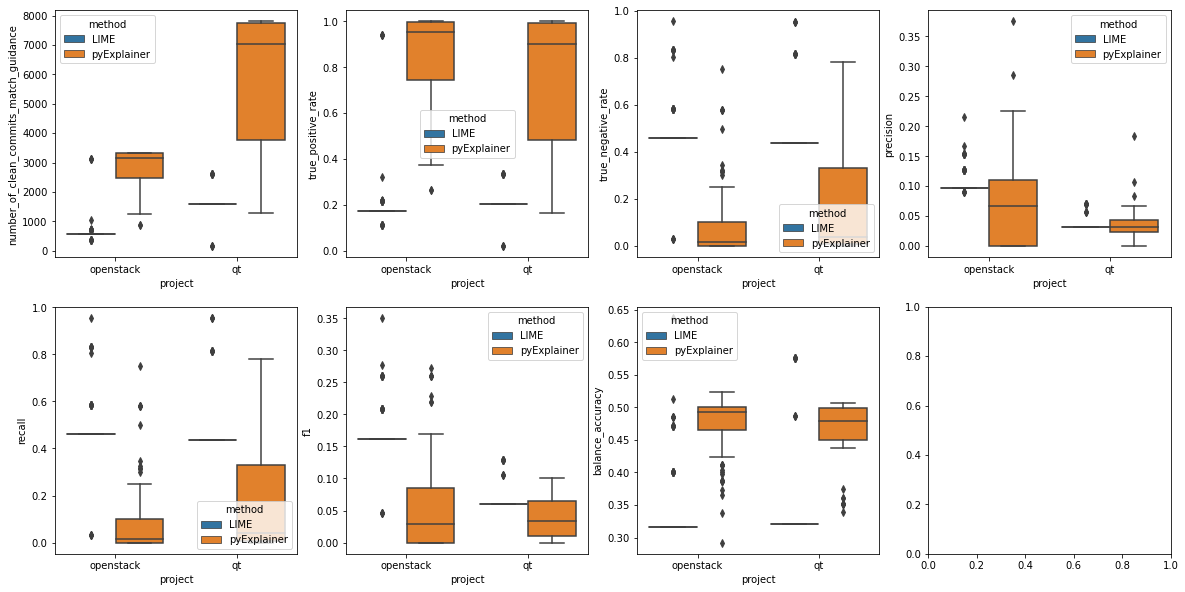

In [23]:
openstack_result_df = pd.read_csv('./eval_result/RQ3_openstack.csv')

qt_result_df = pd.read_csv('./eval_result/RQ3_qt.csv')

fig, axs = plt.subplots(2,4, figsize=(20,10))
result_df = pd.concat([openstack_result_df, qt_result_df])
# display(result_df.head(10))

# plt.ylim(0,100)
sns.boxplot(data=result_df, x='project', y='number_of_clean_commits_match_guidance', hue='method', ax=axs[0,0])
sns.boxplot(data=result_df, x='project', y='true_positive_rate', hue='method', ax=axs[0,1])
sns.boxplot(data=result_df, x='project', y='true_negative_rate', hue='method', ax=axs[0,2])
sns.boxplot(data=result_df, x='project', y='precision', hue='method', ax=axs[0,3])
sns.boxplot(data=result_df, x='project', y='recall', hue='method', ax=axs[1,0])
sns.boxplot(data=result_df, x='project', y='f1', hue='method', ax=axs[1,1])
sns.boxplot(data=result_df, x='project', y='balance_accuracy', hue='method', ax=axs[1,2])

display(result_df[['project','method','number_of_clean_commits_match_guidance', 'true_positive_rate','true_negative_rate']].groupby(['project','method']).describe())

# get the best example from RQ3

In [75]:
# openstack_result_df = pd.read_csv('./eval_result/RQ3_openstack.csv')
# qt_result_df = pd.read_csv('./eval_result/RQ3_qt.csv')

def get_best_example_rq3(proj_name):
    result_df = pd.read_csv('./eval_result/RQ3_'+proj_name+'.csv')
    result_df = result_df.sort_values('true_positive_rate',ascending=False).head(5)
    
    x_test, y_test = prepare_data(proj_name, mode = 'test')
    tmp_df = x_test.copy()
#     print(len(tmp_df))
    tmp_df['label'] = y_test
    tmp_df = tmp_df[tmp_df['label']==False]
#     print(len(tmp_df))
    tmp_df = tmp_df.drop('label',axis=1)
    
    display(tmp_df.head(10))
    
#     print(result_df.columns)
#     display(result_df[['commit id', 'true_positive_rate']])
    
    commits = list(result_df['commit id'])
#     print(commits)
    
    for c in commits:
        py_exp = pickle.load(open(pyExp_dir+proj_name+'_rulefit_crossoverinterpolation_'+c+'.pkl','rb'))
        local_model = py_exp['local_model']
        
        rule = get_rule_str_of_rulefit(local_model)
        guidance = flip_rule(rule)
        
#         print(rule)
        print(guidance)
#         print(py_exp.keys())
#         break
    
get_best_example_rq3('openstack')

,la,nd,ns,ent,nrev,rtime,self,ndev,age,app,rrexp,asawr,rsawr
commit_id,,,,,,,,,,,,,
5ce74eb5469b7f88f4448ccbc1afaa802a7cfdef,17,2,1,0.936667,7.0,17.869722,0,38.0,0.045706,1.0,1306.0,0.113107,0.247377
878ac164a391e761c72c5fdcd12f0caf48c7d359,49,9,3,0.718116,5.0,9.979109,0,116.0,13.035437,4.0,373.0,0.597853,0.296449
bbab55c4da531e4695a6e3e577aaa4975f0fce79,16,2,1,0.988699,6.0,81.107118,0,123.0,0.302407,7.0,2810.0,0.005334,0.389047
a2ba455e2d2bc41f4a80a08d5434b741ed715ef4,519,13,1,0.861772,24.0,16.003877,0,194.0,2.348328,3.0,2086.0,0.122311,0.389511
9382ee659212285a203550cf60476dd146d27a29,89,2,1,0.996276,3.0,105.237789,0,9.0,21.841916,3.0,632.0,0.235955,0.820225
8bc02a7fbeaf2e0c8bccbaad52f41d026c1bbf40,881,9,1,0.878045,7.0,13.612917,0,15.0,5.916775,3.0,194.0,0.055556,0.383333
72d6f6d5f70c0d906ae2a2ac3c44f0b6eaaca8ef,10,1,1,0.000000,3.0,0.705880,0,29.0,5.140880,3.0,200.0,0.033573,0.285372
90620a27e0831345864f574256b30bac1ced5843,44,2,1,0.846439,5.0,19.982674,0,37.0,10.557407,3.0,2219.0,0.006932,0.279417
f7d9d995c23a9fa20912caa9559896e811bcc3c6,1,1,1,0.000000,1.0,2.114896,0,4.0,12.715289,2.0,261.0,0.035885,0.488038


ent > 0.9950000047683716 & ent <= 0.7450000047683716 & ndev > 19.204999923706055 
la <= 18.829999923706055 & rsawr > 0.9549999833106995 & app <= 3.024999976158142 
nrev > 2.990000009536743 & rrexp <= 312.5350036621094 & nrev <= 1.0149999856948853 
asawr > 0.10500000044703484 & app > 3.9950000047683716 & la <= 18.010000228881836 
nrev <= 1.9950000047683716 & nrev <= 2.0199999809265137 


In [63]:
# openstack_result_df = openstack_result_df.sort_values('true_positive_rate',ascending=False)
# qt_result_df = qt_result_df.sort_values('true_positive_rate',ascending=False)
# display(openstack_result_df.head(3))
# display(qt_result_df.head(3))

,project,commit id,method,true_negative,false_positive,false_nagative,number_of_clean_commits_match_guidance,true_positive_rate,true_negative_rate,precision,recall,f1,balance_accuracy
149,openstack,9567c2b6a06aa1e8205f9f30beca63d77500dd1d,pyExplainer,0.0,646.0,0.0,3317.0,1.0,0.0,0.0,0.0,0.0,0.5
161,openstack,9e5a07c8e2f5d7fb3980f538846b53f0d7c62411,pyExplainer,0.0,646.0,0.0,3317.0,1.0,0.0,0.0,0.0,0.0,0.5
270,openstack,c823016d31b36c10cb6faafcce68a1b98f4dc345,pyExplainer,0.0,646.0,0.0,3317.0,1.0,0.0,0.0,0.0,0.0,0.5


,project,commit id,method,true_negative,false_positive,false_nagative,number_of_clean_commits_match_guidance,true_positive_rate,true_negative_rate,precision,recall,f1,balance_accuracy
37,qt,b7a585ebd57f85c89ee20eda5b1a06819b3e1af0,pyExplainer,0.0,476.0,0.0,7801.0,1.0,0.0,0.0,0.0,0.0,0.5
20,qt,2a11286469bf28b348821f015d72f8cb06f54b95,pyExplainer,0.0,476.0,0.0,7801.0,1.0,0.0,0.0,0.0,0.0,0.5
54,qt,eacd58d4e78e7238ba5fcca90ba960aaf3ebd263,pyExplainer,0.0,476.0,0.0,7801.0,1.0,0.0,0.0,0.0,0.0,0.5


In [69]:
# print(op_list)

#### for f in op_list:
####     os.remove(file_dir+'/'+f)
    
# for f in qt_list:
#     os.remove(file_dir+'/'+f)

In [37]:
# x_test, y_test = prepare_data('openstack','test')
# print(len(y_test))

3963


In [38]:
# x_test, y_test = prepare_data('qt','test')
# print(len(y_test))

8277


# code below is not needed (but keep it in case I need it later...)

# ---------------------------------------------------------------------------------------

In [949]:
'''
    Exclusiveness ({rule}->Defect) = lift({rule} -> Defect) / (lift({rule} -> Defect) + lift({rule} -> Clean))

    p = rule (which instances match rules)
    q = Defect/Clean
    lift(p -> q) = support(p -> q)/(support(p)*support(q))
'''


'''
    instance_df: a dataframe of generated instances or test instances
'''
def cal_exculsiveness(rule, instance_df, label):
    
    def cal_lift(support_p_q, support_p, support_q):
        lift = support_p_q/(support_p*support_q) if support_p > 0 and support_q > 0 else 0
        return lift

    label = np.array(label)
    rule_result = eval_rule(rule, instance_df)
    rule_result = np.array(rule_result)
    all_row = len(rule_result)
#     print(rule_result)
    support_p = np.sum(rule_result)/all_row
    
    support_defect = np.sum(label)/all_row
    support_clean = np.sum(label==False)/all_row
    
    support_p_defect = np.sum((rule_result==True)&(label==True))/all_row
    support_p_clean = np.sum((rule_result==True)&(label==False))/all_row
    
    lift_defect = cal_lift(support_p_defect, support_p, support_defect)
    lift_clean = cal_lift(support_p_clean, support_p, support_clean)
    
    exclusiveness = lift_defect/(lift_defect+lift_clean) if lift_defect+lift_clean > 0 else 0
    
#     print(support_p, support_defect, support_clean)
#     print(support_p_defect, support_p_clean)
#     print(lift_defect, lift_clean)
#     print('-'*100)
#     print(lift_defect, lift_clean, exclusiveness)
    return exclusiveness
#     test_df = pd.DataFrame()
#     test_df['rule_result'] = rule_result
#     test_df['label'] = label
    
# #     display(test_df)
#     display(test_df[(test_df['rule_result']==True) & (test_df['label']==True)])
#     display(test_df[(test_df['rule_result']==True) & (test_df['label']==False)])
    
#     print(support_p_defect, support_p_clean)
    
#     print(np.sum(label),all_row)
    
#     print((rule_result==True) and (label==True))
#     print(support_p,support_defect, support_clean)
    
def eval_exclusiveness(proj_name):
    global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name)
    x_train, x_test, y_train, y_test = prepare_data(proj_name, mode = 'all')
    
    categorical_features_list = [6]
    class_label = ['clean', 'defect']
    
    lime_explainer = LimeTabularExplainer(x_train.values, categorical_features=categorical_features_list, 
                                      feature_names=indep, class_names=class_label, discretizer = 'decile',
                                      random_state=0)
    
    all_cols = x_train.columns
    
    all_eval_result = pd.DataFrame()
    
    for i in range(0,len(feature_df)):
        X_explain = feature_df.iloc[[i]]

        row_index = str(X_explain.index[0])

        py_exp = pickle.load(open(pyExp_dir+proj_name+'_rulefit_crossoverinterpolation_'+row_index+'_20_rules.pkl','rb'))
        lime_exp = pickle.load(open(pyExp_dir+proj_name+'_lime_'+row_index+'.pkl','rb'))

        py_exp_local_model = py_exp['local_model']
        lime_exp_local_model = lime_exp['local_model']
        selected_feature_indices = lime_exp['selected_feature_indeces']

        py_exp_gen_inst =  py_exp['synthetic_data']
        py_exp_gen_pred = py_exp['synthetic_predictions']
        
        lime_gen_inst = lime_exp['synthetic_instance_for_global_model']
        lime_gen_inst_local = lime_exp['synthetic_instance_for_lobal_model']
        lime_gen_inst_pred = global_model.predict(lime_gen_inst)

        lime_selected_col = all_cols[selected_feature_indices]
        lime_gen_inst = lime_gen_inst[:,selected_feature_indices]  
        lime_gen_inst_local_df = pd.DataFrame(data=lime_gen_inst, columns=lime_selected_col)

        py_exp_the_best_defective_rule_str = get_rule_str_of_rulefit_new_version(py_exp_local_model)
        lime_the_best_defective_rule_str = lime_exp['rule'].as_list()[0][0]
        
        py_exp_excls_x_test = cal_exculsiveness(py_exp_the_best_defective_rule_str, x_test, y_test)
        
        lime_exp_excls_x_test = cal_exculsiveness(lime_the_best_defective_rule_str, x_test, y_test)
        
        py_exp_excls_gen_inst = cal_exculsiveness(py_exp_the_best_defective_rule_str, py_exp_gen_inst, 
                                                  py_exp_gen_pred)
        lime_exp_excls_gen_inst = cal_exculsiveness(lime_the_best_defective_rule_str, lime_gen_inst_local_df, 
                                                    lime_gen_inst_pred)
        
        py_exp_excls_serie =  pd.Series(data=[proj_name, row_index, 'crossover_interpolation',
                                              py_exp_excls_x_test, py_exp_excls_gen_inst])
        lime_excls_serie =  pd.Series(data=[proj_name, row_index, 'LIME',
                                            lime_exp_excls_x_test, lime_exp_excls_gen_inst])
        
        all_eval_result = all_eval_result.append(py_exp_excls_serie,ignore_index=True)
        all_eval_result = all_eval_result.append(lime_excls_serie,ignore_index=True)
            
        print('finished {} from {} commits'.format(str(i+1),len(feature_df)))
        
#         print(py_exp_excls_gen_inst, lime_exp_excls_gen_inst)
#         py_exp_excls_gen_inst = cal_exculsiveness(py_exp_the_best_defective_rule_str, py_exp_gen_inst, py_exp_gen_pred)
#         print(py_exp.keys())
#         print(lime_exp.keys())
#         break

    all_eval_result.columns = ['project', 'commit id', 'method', 'exclusiveness_x_test','exclusiveness_generated_instances']
    
    all_eval_result.to_csv(result_dir+'RQ555_'+proj_name+'_exclusiveness_lime_decile_20_rules.csv',index=False)
    print('finished',proj_name)
        

In [950]:
eval_exclusiveness('openstack') # runs fine
eval_exclusiveness('qt')

finished 1 from 198 commits
finished 2 from 198 commits
finished 3 from 198 commits
finished 4 from 198 commits
finished 5 from 198 commits
finished 6 from 198 commits
finished 7 from 198 commits
finished 8 from 198 commits
finished 9 from 198 commits
finished 10 from 198 commits
finished 11 from 198 commits
finished 12 from 198 commits
finished 13 from 198 commits
finished 14 from 198 commits
finished 15 from 198 commits
finished 16 from 198 commits
finished 17 from 198 commits
finished 18 from 198 commits
finished 19 from 198 commits
finished 20 from 198 commits
finished 21 from 198 commits
finished 22 from 198 commits
finished 23 from 198 commits
finished 24 from 198 commits
finished 25 from 198 commits
finished 26 from 198 commits
finished 27 from 198 commits
finished 28 from 198 commits
finished 29 from 198 commits
finished 30 from 198 commits
finished 31 from 198 commits
finished 32 from 198 commits
finished 33 from 198 commits
finished 34 from 198 commits
finished 35 from 198 co

In [955]:
openstack_result_df = pd.read_csv('./eval_result/RQ555_openstack_exclusiveness_lime_decile_20_rules.csv')
qt_result_df = pd.read_csv('./eval_result/RQ555_qt_exclusiveness_lime_decile_20_rules.csv')

result_df = pd.concat([openstack_result_df, qt_result_df])
display(result_df.head())

# plt.ylim(0,1)

sns.set(rc={'figure.figsize':(5,5)})

display(result_df.groupby(['project','method']).describe())

,project,commit id,method,exclusiveness_x_test,exclusiveness_generated_instances
0,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,crossover_interpolation,0.538440,0.439903
1,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,LIME,0.811641,0.742125
2,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,crossover_interpolation,0.605374,0.709630
3,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,LIME,0.811641,0.738125
4,openstack,de31210c05f464c4a79255de68b1a515d9b84ed3,crossover_interpolation,0.267056,0.127847


exclusiveness_x_test                      \
                                                 count      mean       std   
project   method                                                             
openstack LIME                                   198.0  0.748065  0.076185   
          crossover_interpolation                198.0  0.643627  0.130802   
qt        LIME                                    79.0  0.346923  0.383906   
          crossover_interpolation                 79.0  0.548290  0.273987   

                                                                           \
                                        min       25%       50%       75%   
project   method                                                            
openstack LIME                     0.457408  0.723086  0.811641  0.811641   
          crossover_interpolation  0.189012  0.597944  0.650343  0.753098   
qt        LIME                     0.000000  0.000000  0.000000  0.820066   
          crossover_interpolation  0.000000  0.475391  0.641284  0.727875   

                                            exclusiveness_generated_instances  \
                                        max                             count   
project   method                                                                
openstack LIME                     0.811641                             198.0   
          crossover_interpolation  0.814992                             198.0   
qt        LIME                     0.820066                              79.0   
          crossover_interpolation  0.860513                              79.0   

                                                                           \
                                       mean       std       min       25%   
project   method                                                            
openstack LIME                     0.715139  0.038353  0.514525  0.696486   
          crossover_interpolation  0.658427  0.158961  0.100997  0.662777   
qt        LIME                     0.363442  0.374537  0.000000  0.000000   
          crossover_interpolation  0.720934  0.169926  0.189698  0.664064   

                                                                 
                                        50%       75%       max  
project   method                                                 
openstack LIME                     0.721188  0.739100  0.810861  
          crossover_interpolation  0.694213  0.723691  0.926643  
qt        LIME                     0.000000  0.748105  0.852876  
          crossover_interpolation  0.712520  0.755920  1.000000

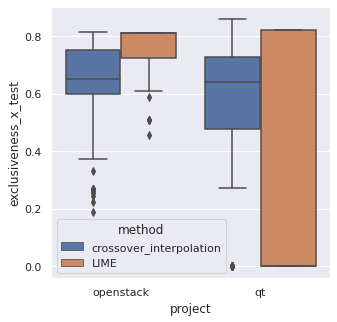

In [952]:
sns.boxplot(data=result_df, x='project', y='exclusiveness_x_test', hue='method')
plt.show()


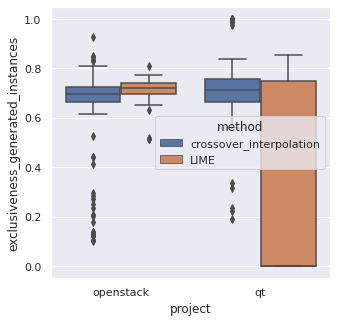

In [953]:
sns.boxplot(data=result_df, x='project', y='exclusiveness_generated_instances', hue='method')
plt.show()

In [ ]:
# note: defective commit is correctly predicted as defective commit
def predict_defective_commit_by_local_model(proj_name):
    global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name)
    x_train, x_test, y_train, y_test = prepare_data(proj_name, mode = 'all')
    
    categorical_features_list = [6]
    class_label = ['clean', 'defect']
    
    lime_explainer = LimeTabularExplainer(x_train.values, categorical_features=categorical_features_list, 
                                      feature_names=indep, class_names=class_label, discretizer = 'decile',
                                      random_state=0)
    
    py_exp_pred_count = 0
    lime_pred_count = 0
    
    for i in range(0,len(feature_df)):
        X_explain = feature_df.iloc[[i]]

        row_index = str(X_explain.index[0])

        py_exp = pickle.load(open(pyExp_dir+proj_name+'_rulefit_crossoverinterpolation_'+row_index+'_20_rules.pkl','rb'))
        lime_exp = pickle.load(open(pyExp_dir+proj_name+'_lime_'+row_index+'.pkl','rb'))

        py_exp_local_model = py_exp['local_model']
        lime_exp_local_model = lime_exp['local_model']
        selected_feature_indices = lime_exp['selected_feature_indeces']

        py_exp_pred = py_exp_local_model.predict(X_explain.values)
        
        lime_feature = np.ones((1,len(selected_feature_indices)))
        lime_prob = lime_exp_local_model.predict(lime_feature)
        lime_pred = np.round(lime_prob).astype(bool)
              
        if py_exp_pred:
            py_exp_pred_count = py_exp_pred_count +1
        if lime_pred:
            lime_pred_count = lime_pred_count + 1
            
    print(py_exp_pred_count, lime_pred_count)
    print('finished RQ555 of',proj_name)

In [ ]:
def get_median_local_feature_rank(sorted_global_feature, rule):
    var_in_rule = list(set(re.findall('[a-zA-Z]+', rule)))
    var_rank = [sorted_global_feature.index(var)+1 for var in var_in_rule]
    return np.median(var_rank)

def get_local_feature_rank(proj_name):
    global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name)
    x_train, x_test, y_train, y_test = prepare_data(proj_name, mode = 'all')
    
    eval_result = pd.DataFrame()
    
    sorted_global_feature = sort_global_feature(global_model, indep)
#     print(sorted_global_feature)
    
#     py_exp_med_rank = []
    
    for i in range(0,len(feature_df)):
        X_explain = feature_df.iloc[[i]]

        row_index = str(X_explain.index[0])

        py_exp = pickle.load(open(pyExp_dir+proj_name+'_rulefit_crossoverinterpolation_'+row_index+'_20_rules.pkl','rb'))
        lime_exp = pickle.load(open(pyExp_dir+proj_name+'_lime_'+row_index+'.pkl','rb'))

        py_exp_local_model = py_exp['local_model']
        lime_exp_local_model = lime_exp['local_model']
        
        py_exp_the_best_defective_rule_str = get_rule_str_of_rulefit(py_exp_local_model)
        lime_the_best_defective_rule_str = lime_exp['rule'].as_list()[0][0]
        
        py_exp_med_rank = get_median_local_feature_rank(sorted_global_feature, py_exp_the_best_defective_rule_str)
        lime_med_rank = get_median_local_feature_rank(sorted_global_feature, lime_the_best_defective_rule_str)
        
        py_exp_serie = pd.Series(data=[proj_name, row_index, 'crossover_interpolation',py_exp_med_rank])
        lime_exp_serie = pd.Series(data=[proj_name, row_index, 'LIME', lime_med_rank])
        
        eval_result = eval_result.append(py_exp_serie,ignore_index=True)
        eval_result = eval_result.append(lime_exp_serie, ignore_index=True)
        
#         py_exp_var_in_rule = list(set(re.findall('[a-zA-Z]+', py_exp_the_best_defective_rule_str)))
#         lime_var_in_rule = list(set(re.findall('[a-zA-Z]+', lime_the_best_defective_rule_str)))

#         print(py_exp_the_best_defective_rule_str)
#         print(py_exp_var_in_rule)
        
#         print(lime_the_best_defective_rule_str)
#         print(lime_var_in_rule)
        
#         py_exp_var_rank = [sorted_global_feature.index(var)+1 for var in py_exp_var_in_rule]
#         lime_var_rank = [sorted_global_feature.index(var)+1 for var in lime_var_in_rule]
        
#         print(py_exp_var_rank, lime_var_rank)
#         break

    eval_result.columns = ['project', 'commit id', 'method', 'median_local_feature_rank']
    eval_result.to_csv(result_dir+'RQ3_555_'+proj_name+'_median_local_feature_rank_20_rules.csv',index=False)
    
    print('finished',proj_name)
    
    
# def check_r2_score(proj_name):
#     global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name)
#     x_train, x_test, y_train, y_test = prepare_data(proj_name, mode = 'all')
    
#     eval_result = pd.DataFrame()
    
# #     print(sorted_global_feature)
    
# #     py_exp_med_rank = []
    
#     for i in range(0,len(feature_df)):
#         X_explain = feature_df.iloc[[i]]

#         row_index = str(X_explain.index[0])

#         py_exp = pickle.load(open(pyExp_dir+proj_name+'_rulefit_crossoverinterpolation_'+row_index+'.pkl','rb'))
#         lime_exp = pickle.load(open(pyExp_dir+proj_name+'_lime_'+row_index+'.pkl','rb'))

#         py_exp_local_model = py_exp['local_model']
#         lime_exp_local_model = lime_exp['local_model']
        
#         # this data can be used for both local and global model
#         py_exp_synthetic_data = py_exp['synthetic_data'].values
#         # this data can be used with global model only
#         lime_exp_synthetic_data = lime_exp['synthetic_instance_for_global_model']
#         # this data can be used with local model only
#         lime_exp_synthetic_data_local = lime_exp['synthetic_instance_for_lobal_model']
        
#         py_exp_train_pred = global_model.predict(py_exp_synthetic_data).astype(int)
#         py_exp_local_pred = py_exp_local_model.predict(py_exp_synthetic_data).astype(int)
        
# #         print(py_exp_train_pred)
# #         print(py_exp_local_pred)
#         lime_train_prob = global_model.predict_proba(lime_exp_synthetic_data)[:,1]
#         lime_local_prob = lime_exp_local_model.predict(lime_exp_synthetic_data_local)
        
#         py_exp_r2_score = r2_score(py_exp_train_pred, py_exp_local_pred)
#         lime_r2_score = r2_score(lime_train_prob, lime_local_prob)
        
#         py_exp_serie = pd.Series(data=[proj_name, row_index, 'crossover_interpolation',py_exp_r2_score])
#         lime_exp_serie = pd.Series(data=[proj_name, row_index, 'LIME', lime_r2_score])
        
#         eval_result = eval_result.append(py_exp_serie,ignore_index=True)
#         eval_result = eval_result.append(lime_exp_serie, ignore_index=True)
        
#     eval_result.columns = ['project', 'commit id', 'method', 'r2_score']
#     eval_result.to_csv(result_dir+'RQ3_555_'+proj_name+'_r2_score.csv',index=False)
    
#     print('finished',proj_name)
# #         print(py_exp_r2_score, lime_r2_score)
        
# #         break

In [765]:
# predict_defective_commit_by_local_model('openstack')
# predict_defective_commit_by_local_model('qt')
# print('-'*100)
# predict_defective_commit_by_rule('openstack')
# predict_defective_commit_by_rule('qt')

In [703]:
# print(f1_score([1,1,1,1],[0,1,0,1]))

In [971]:
def predict_test_defective_commit_by_rule(proj_name):
    global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name)
    x_test, y_test = prepare_data(proj_name, mode = 'test')
    
    test_df = x_test.copy()
    test_df['label'] = list(y_test)
    test_df = test_df[test_df['label']==True]
    test_df = test_df.drop('label',axis=1)

    categorical_features_list = [6]
    class_label = ['clean', 'defect']
    
    lime_explainer = LimeTabularExplainer(x_train.values, categorical_features=categorical_features_list, 
                                      feature_names=indep, class_names=class_label, discretizer = 'decile',
                                      random_state=0)
    
    all_eval_result = pd.DataFrame()
    
    py_exp_pred_count = 0
    lime_pred_count = 0
    
    for i in range(0,len(feature_df)):
        X_explain = feature_df.iloc[[i]]
        row_index = str(X_explain.index[0])

        py_exp = pickle.load(open(pyExp_dir+proj_name+'_rulefit_crossoverinterpolation_'+row_index+'_20_rules.pkl','rb'))
        lime_exp = pickle.load(open(pyExp_dir+proj_name+'_lime_'+row_index+'.pkl','rb'))

        py_exp_local_model = py_exp['local_model']
        lime_exp_local_model = lime_exp['local_model']
        selected_feature_indices = lime_exp['selected_feature_indeces']

        py_exp_the_best_defective_rule_str = get_rule_str_of_rulefit_new_version(py_exp_local_model)
        lime_the_best_defective_rule_str = lime_exp['rule'].as_list()[0][0]
        
        py_exp_pred = eval_rule(py_exp_the_best_defective_rule_str, X_explain)[0]
        lime_pred = eval_rule(lime_the_best_defective_rule_str, X_explain)[0]

        if py_exp_pred == 1: # and lime_pred == 1:
            py_exp_all_eval_result = eval_rule(py_exp_the_best_defective_rule_str, test_df)
            py_exp_percent_correct = np.sum(py_exp_all_eval_result)/len(test_df)
            py_exp_serie = pd.Series(data=[proj_name, row_index, 'crossover_interpolation',
                                       py_exp_percent_correct])
            all_eval_result = all_eval_result.append(py_exp_serie,ignore_index=True)
            
#             py_exp_pred_count = py_exp_pred_count+1
            
        if lime_pred == 1:
            lime_all_eval_result = eval_rule(lime_the_best_defective_rule_str, test_df)
            lime_percent_correct = np.sum(lime_all_eval_result)/len(test_df)
            lime_exp_serie = pd.Series(data=[proj_name, row_index, 'LIME',
                                          lime_percent_correct])
            all_eval_result = all_eval_result.append(lime_exp_serie, ignore_index=True)

    all_eval_result.columns = ['project', 'commit id', 'method', 'correctly_predict_ratio']

    all_eval_result.to_csv(result_dir+'RQ3_'+proj_name+'_test_defective_commit_prediction_by_rule_lime_decile_20_rules_new.csv',index=False)
#     print(py_exp_pred_count, lime_pred_count)
    print('finished RQ555 of',proj_name)

In [972]:
predict_test_defective_commit_by_rule('openstack')
predict_test_defective_commit_by_rule('qt')

0 0
finished RQ555 of openstack
0 0
finished RQ555 of qt


,project,commit id,method,correctly_predict_ratio
0,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,crossover_interpolation,0.605263
1,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,LIME,0.258514
2,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,LIME,0.258514
3,openstack,de31210c05f464c4a79255de68b1a515d9b84ed3,LIME,0.184211
4,openstack,957533f685caf9ffc0d9cad569598455d59ade34,crossover_interpolation,0.404025


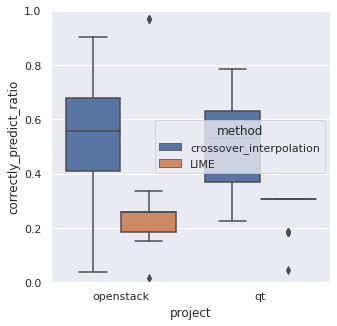

correctly_predict_ratio                      \
                                                    count      mean       std   
project   method                                                                
openstack LIME                                      198.0  0.234317  0.103856   
          crossover_interpolation                   138.0  0.541897  0.179807   
qt        LIME                                       38.0  0.274215  0.062921   
          crossover_interpolation                    39.0  0.506141  0.156524   

                                                                           \
                                        min       25%       50%       75%   
project   method                                                            
openstack LIME                     0.017028  0.184211  0.258514  0.258514   
          crossover_interpolation  0.037152  0.410991  0.556502  0.678793   
qt        LIME                     0.046218  0.306723  0.306723  0.306723   
          crossover_interpolation  0.226891  0.368697  0.529412  0.629202   

                                             
                                        max  
project   method                             
openstack LIME                     0.969040  
          crossover_interpolation  0.900929  
qt        LIME                     0.306723  
          crossover_interpolation  0.783613

In [973]:
openstack_result_df = pd.read_csv('./eval_result/RQ3_openstack_test_defective_commit_prediction_by_rule_lime_decile_20_rules_new.csv')
qt_result_df = pd.read_csv('./eval_result/RQ3_qt_test_defective_commit_prediction_by_rule_lime_decile_20_rules_new.csv')

result_df = pd.concat([openstack_result_df, qt_result_df])
display(result_df.head())

plt.ylim(0,1)

sns.set(rc={'figure.figsize':(5,5)})

sns.boxplot(data=result_df, x='project', y='correctly_predict_ratio', hue='method')
plt.show()

display(result_df.groupby(['project','method']).describe())

In [706]:
# check_r2_score('openstack')
# check_r2_score('qt')

In [707]:
# openstack_result_df = pd.read_csv('./eval_result/RQ3_555_openstack_r2_score.csv')
# qt_result_df = pd.read_csv('./eval_result/RQ3_555_qt_r2_score.csv')

# result_df = pd.concat([openstack_result_df, qt_result_df])
# display(result_df.head())

# plt.ylim(-1,1)
# sns.boxplot(data=result_df, x='project', y='r2_score', hue='method')
# plt.show()

In [855]:
# get_local_feature_rank('openstack')
# get_local_feature_rank('qt')

In [856]:
# openstack_result_df = pd.read_csv('./eval_result/RQ3_555_openstack_median_local_feature_rank_20_rules.csv')
# qt_result_df = pd.read_csv('./eval_result/RQ3_555_qt_median_local_feature_rank_20_rules.csv')

# result_df = pd.concat([openstack_result_df, qt_result_df])
# display(result_df.head())

# sns.boxplot(data=result_df, x='project', y='median_local_feature_rank', hue='method')
# plt.show()

In [974]:
def predict_test_commit_by_rule(proj_name):
    global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name)
    x_test, y_test = prepare_data(proj_name, mode = 'test')
    
    categorical_features_list = [6]
    class_label = ['clean', 'defect']
    
    lime_explainer = LimeTabularExplainer(x_train.values, categorical_features=categorical_features_list, 
                                      feature_names=indep, class_names=class_label, discretizer = 'decile',
                                      random_state=0)
    
    all_eval_result = pd.DataFrame()
    
    for i in range(0,len(feature_df)):
        X_explain = feature_df.iloc[[i]]
        row_index = str(X_explain.index[0])

        py_exp = pickle.load(open(pyExp_dir+proj_name+'_rulefit_crossoverinterpolation_'+row_index+'_20_rules.pkl','rb'))
        lime_exp = pickle.load(open(pyExp_dir+proj_name+'_lime_'+row_index+'.pkl','rb'))

        py_exp_local_model = py_exp['local_model']
        lime_exp_local_model = lime_exp['local_model']
        selected_feature_indices = lime_exp['selected_feature_indeces']

        py_exp_the_best_defective_rule_str = get_rule_str_of_rulefit_new_version(py_exp_local_model)
        lime_the_best_defective_rule_str = lime_exp['rule'].as_list()[0][0]
        
        py_exp_pred = eval_rule(py_exp_the_best_defective_rule_str, X_explain)[0]
        lime_pred = eval_rule(lime_the_best_defective_rule_str, X_explain)[0]

        if py_exp_pred == 1:
            py_exp_all_eval_result = eval_rule(py_exp_the_best_defective_rule_str, x_test)
            py_exp_f1 = f1_score(y_test, py_exp_all_eval_result)
            py_exp_mcc = matthews_corrcoef(y_test, py_exp_all_eval_result)
            py_exp_bal_acc = balanced_accuracy_score(y_test, py_exp_all_eval_result)
            py_exp_serie = pd.Series(data=[proj_name, row_index, 'crossover_interpolation',
                                       py_exp_bal_acc, py_exp_f1, py_exp_mcc])
            all_eval_result = all_eval_result.append(py_exp_serie,ignore_index=True)
            
        if lime_pred == 1:
            lime_all_eval_result = eval_rule(lime_the_best_defective_rule_str, x_test)
            lime_f1 = f1_score(y_test, lime_all_eval_result)
            lime_mcc = matthews_corrcoef(y_test, lime_all_eval_result)
            lime_bal_acc = balanced_accuracy_score(y_test, lime_all_eval_result)
            lime_exp_serie = pd.Series(data=[proj_name, row_index, 'LIME',
                                              lime_bal_acc, lime_f1, lime_mcc])
            all_eval_result = all_eval_result.append(lime_exp_serie, ignore_index=True)

    all_eval_result.columns = ['project', 'commit id', 'method', 'balanced_accuracy', 'F1','MCC']
    
    display(all_eval_result)
    all_eval_result.to_csv(result_dir+'RQ555_'+proj_name+'_test_commit_prediction_by_rule_lime_decile_20_rules_new.csv',index=False)

    print('finished RQ555 of',proj_name)
    

In [975]:
start = time.time()
print('openstack')
predict_test_commit_by_rule('openstack')
end = time.time()
print('finished in',str(end-start), 'secs')

start = time.time()
print('qt')
predict_test_commit_by_rule('qt')
end = time.time()
print('finished in',str(end-start), 'secs')

openstack


,project,commit id,method,balanced_accuracy,F1,MCC
0,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,crossover_interpolation,0.543210,0.283539,0.063982
1,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,LIME,0.599260,0.330040,0.253269
2,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,LIME,0.599260,0.330040,0.253269
3,openstack,de31210c05f464c4a79255de68b1a515d9b84ed3,LIME,0.556832,0.238238,0.147392
4,openstack,957533f685caf9ffc0d9cad569598455d59ade34,crossover_interpolation,0.647445,0.411348,0.299248
...,...,...,...,...,...,...
331,openstack,605749ca12af969ac122008b4fa14904df68caf7,LIME,0.599260,0.330040,0.253269
332,openstack,85239cc81440d9e5a4aee3c0961c96a4197ad939,crossover_interpolation,0.665311,0.430813,0.310821
333,openstack,85239cc81440d9e5a4aee3c0961c96a4197ad939,LIME,0.599260,0.330040,0.253269
334,openstack,f0f52a0085a1f5bbd23e6cfa8f0ea935e8fd56c8,crossover_interpolation,0.666530,0.381022,0.246310


finished RQ555 of openstack
finished in 218.30340051651 secs
qt


,project,commit id,method,balanced_accuracy,F1,MCC
0,qt,f5dbc876378ae58a7bdfe1e9664fc81caca18dfb,crossover_interpolation,0.662335,0.176655,0.153908
1,qt,9d75626b1073113d77988bcb52e99215d5af4787,crossover_interpolation,0.506967,0.108364,0.007146
2,qt,3168c94577cc604fd033ce4e741da5c411f74666,crossover_interpolation,0.629689,0.263333,0.213738
3,qt,23bdca417bde716c79168ab372083fd885607123,LIME,0.619712,0.254577,0.204224
4,qt,438211ec627073817fcaf6d3a07b76f2aa5d90e0,crossover_interpolation,0.582614,0.141216,0.079513
...,...,...,...,...,...,...
72,qt,2b67b50af18bb2a17ff10d5a37abfd85fc7e9d01,LIME,0.619712,0.254577,0.204224
73,qt,5f0023a7469e01bada70fbe677b76bb535eaa953,crossover_interpolation,0.651077,0.199765,0.162253
74,qt,5f0023a7469e01bada70fbe677b76bb535eaa953,LIME,0.424766,0.055346,-0.074692
75,qt,7c737e0edcb93585856c65890ef34e5c5a28ee6b,crossover_interpolation,0.651462,0.200236,0.162823


finished RQ555 of qt
finished in 108.34721422195435 secs


,project,commit id,method,balanced_accuracy,F1,MCC
0,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,crossover_interpolation,0.543210,0.283539,0.063982
1,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,LIME,0.599260,0.330040,0.253269
2,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,LIME,0.599260,0.330040,0.253269
3,openstack,de31210c05f464c4a79255de68b1a515d9b84ed3,LIME,0.556832,0.238238,0.147392
4,openstack,957533f685caf9ffc0d9cad569598455d59ade34,crossover_interpolation,0.647445,0.411348,0.299248


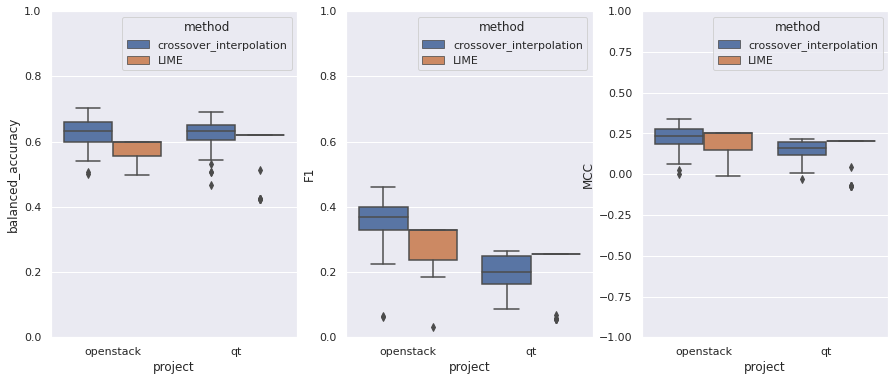

balanced_accuracy                      \
                                              count      mean       std   
project   method                                                          
openstack LIME                                198.0  0.575099  0.027960   
          crossover_interpolation             138.0  0.627763  0.043571   
qt        LIME                                 38.0  0.575862  0.080933   
          crossover_interpolation              39.0  0.620744  0.052139   

                                                                           \
                                        min       25%       50%       max   
project   method                                                            
openstack LIME                     0.498414  0.556832  0.599260  0.599260   
          crossover_interpolation  0.499774  0.599371  0.633216  0.701666   
qt        LIME                     0.424766  0.619712  0.619712  0.619712   
          crossover_interpolation  0.466911  0.605303  0.633924  0.691901   

                                      F1                                \
                                   count      mean       std       min   
project   method                                                         
openstack LIME                     198.0  0.280574  0.058066  0.030387   
          crossover_interpolation  138.0  0.359781  0.060701  0.063492   
qt        LIME                      38.0  0.207699  0.085297  0.055346   
          crossover_interpolation   39.0  0.195911  0.051346  0.085328   

                                                                   MCC  \
                                        25%       50%       max  count   
project   method                                                         
openstack LIME                     0.238238  0.330040  0.330040  198.0   
          crossover_interpolation  0.328474  0.369233  0.461078  138.0   
qt        LIME                     0.254577  0.254577  0.254577   38.0   
          crossover_interpolation  0.162439  0.200236  0.263333   39.0   

                                                                           \
                                       mean       std       min       25%   
project   method                                                            
openstack LIME                     0.189634  0.070802 -0.008433  0.147392   
          crossover_interpolation  0.219612  0.073537 -0.000845  0.183079   
qt        LIME                     0.141221  0.116017 -0.074692  0.204224   
          crossover_interpolation  0.147464  0.066099 -0.031363  0.119416   

                                                       
                                        50%       max  
project   method                                       
openstack LIME                     0.253269  0.253269  
          crossover_interpolation  0.234979  0.340331  
qt        LIME                     0.204224  0.204224  
          crossover_interpolation  0.163794  0.216112

In [978]:
openstack_result_df = pd.read_csv('./eval_result/RQ555_openstack_test_commit_prediction_by_rule_lime_decile_20_rules_new.csv')
qt_result_df = pd.read_csv('./eval_result/RQ555_qt_test_commit_prediction_by_rule_lime_decile_20_rules_new.csv')

result_df = pd.concat([openstack_result_df, qt_result_df])
display(result_df.head())

fig, axs = plt.subplots(1,3, figsize=(15,6))

axs[0].set_ylim([0, 1]) 
sns.boxplot(data=result_df, x='project', y='balanced_accuracy', hue='method', ax=axs[0])

axs[1].set_ylim([0, 1]) 
sns.boxplot(data=result_df, x='project', y='F1', hue='method', ax=axs[1])

axs[2].set_ylim([-1, 1]) 
sns.boxplot(data=result_df, x='project', y='MCC', hue='method', ax=axs[2])

plt.show()
display(result_df.groupby(['project','method']).describe(percentiles=[.25,.5]))

In [ ]:
## use local model to predict test instance
def predict_test_commit_by_local_model(proj_name):
    global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name)
    x_train, x_test, y_train, y_test = prepare_data(proj_name, mode = 'all')
    
    categorical_features_list = [6]
    class_label = ['clean', 'defect']
    
    lime_explainer = LimeTabularExplainer(x_train.values, categorical_features=categorical_features_list, 
                                      feature_names=indep, class_names=class_label, discretizer = 'decile',
                                      random_state=0)
    
    all_eval_result = pd.DataFrame()
    
    py_exp_pred_count = 0
    lime_pred_count = 0
    
    for i in range(0,len(feature_df)):
        X_explain = feature_df.iloc[[i]]

        row_index = str(X_explain.index[0])

        py_exp = pickle.load(open(pyExp_dir+proj_name+'_rulefit_crossoverinterpolation_'+row_index+'_20_rules.pkl','rb'))
        lime_exp = pickle.load(open(pyExp_dir+proj_name+'_lime_'+row_index+'.pkl','rb'))

        py_exp_local_model = py_exp['local_model']
        lime_exp_local_model = lime_exp['local_model']
        selected_feature_indices = lime_exp['selected_feature_indeces']
        
        py_exp_prob = py_exp_local_model.predict_proba(x_test.values)[:,1]
        py_exp_pred = py_exp_local_model.predict(x_test.values)
        
        lime_discretized_sample = lime_explainer.discretizer.discretize(X_explain.values)
        discretized_x_test = lime_explainer.discretizer.discretize(x_test.values)
        compare_discretized_val = (lime_discretized_sample==discretized_x_test).astype(int)
        compare_discretized_val = (compare_discretized_val - lime_explainer.scaler.mean_) / lime_explainer.scaler.scale_
        compare_discretized_val = compare_discretized_val[:,selected_feature_indices]
        lime_prob = lime_exp_local_model.predict(compare_discretized_val)
        lime_pred = np.round(lime_prob).astype(bool)
#         print(lime_pred)

        py_exp_auc = roc_auc_score(y_test, py_exp_prob)
        py_exp_f1 = f1_score(y_test, py_exp_pred)
        py_exp_mcc = matthews_corrcoef(y_test, py_exp_pred)
        py_exp_bal_acc = balanced_accuracy_score(y_test, py_exp_pred)
        
        lime_auc = roc_auc_score(y_test, lime_prob)
        lime_f1 = f1_score(y_test, lime_pred)
        lime_mcc = matthews_corrcoef(y_test, lime_pred)
        lime_bal_acc = balanced_accuracy_score(y_test, lime_pred)
        
        py_exp_serie = pd.Series(data=[proj_name, row_index, 'crossover_interpolation',
                                       py_exp_bal_acc, py_exp_auc, py_exp_f1, py_exp_mcc])
        lime_exp_serie = pd.Series(data=[proj_name, row_index, 'LIME',
                                          lime_bal_acc, lime_auc, lime_f1, lime_mcc])
        
        all_eval_result = all_eval_result.append(py_exp_serie,ignore_index=True)
        all_eval_result = all_eval_result.append(lime_exp_serie, ignore_index=True)

    all_eval_result.columns = ['project', 'commit id', 'method', 'balanced_accuracy', 'AUC', 'F1','MCC']
    
    display(all_eval_result)
    all_eval_result.to_csv(result_dir+'RQ555_'+proj_name+'_test_commit_prediction_by_local_model_lime_decile_20_rules.csv',index=False)

    print(py_exp_pred_count, lime_pred_count)
    print('finished RQ555 of',proj_name)

In [713]:
start = time.time()
print('openstack')
predict_test_commit_by_local_model('openstack')
end = time.time()
print('finished in',str(end-start), 'secs')

start = time.time()
print('qt')
predict_test_commit_by_local_model('qt')
end = time.time()
print('finished in',str(end-start), 'secs')

openstack


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalar

,project,commit id,method,balanced_accuracy,AUC,F1,MCC
0,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,crossover_interpolation,0.617947,0.684904,0.352800,0.199622
1,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,LIME,0.514787,0.605924,0.066763,0.105445
2,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,crossover_interpolation,0.666248,0.701339,0.410169,0.272464
3,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,LIME,0.543697,0.637545,0.173456,0.192313
4,openstack,de31210c05f464c4a79255de68b1a515d9b84ed3,crossover_interpolation,0.659263,0.709934,0.375369,0.235524
...,...,...,...,...,...,...,...
391,openstack,605749ca12af969ac122008b4fa14904df68caf7,LIME,0.527493,0.654035,0.112835,0.162381
392,openstack,85239cc81440d9e5a4aee3c0961c96a4197ad939,crossover_interpolation,0.564755,0.667203,0.259643,0.155903
393,openstack,85239cc81440d9e5a4aee3c0961c96a4197ad939,LIME,0.526438,0.632401,0.111732,0.148269
394,openstack,f0f52a0085a1f5bbd23e6cfa8f0ea935e8fd56c8,crossover_interpolation,0.633016,0.672643,0.364268,0.206650


0 0
finished RQ555 of openstack
finished in 3.422733783721924 secs
qt


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalar

,project,commit id,method,balanced_accuracy,AUC,F1,MCC
0,qt,f5dbc876378ae58a7bdfe1e9664fc81caca18dfb,crossover_interpolation,0.647752,0.709811,0.214353,0.172518
1,qt,f5dbc876378ae58a7bdfe1e9664fc81caca18dfb,LIME,0.501050,0.598034,0.004193,0.044500
2,qt,602bd9873786ccadcb67da3036329f3122555cf8,crossover_interpolation,0.625379,0.680174,0.168553,0.124476
3,qt,602bd9873786ccadcb67da3036329f3122555cf8,LIME,0.500000,0.545652,0.000000,0.000000
4,qt,9d75626b1073113d77988bcb52e99215d5af4787,crossover_interpolation,0.545003,0.601962,0.119353,0.044471
...,...,...,...,...,...,...,...
153,qt,9bb634a6176c639bd6b52d58151e9927c30919d0,LIME,0.501050,0.492555,0.004193,0.044500
154,qt,1e8de50674f5b33a50c45224b7e07b3f974f6ab0,crossover_interpolation,0.622744,0.688596,0.182410,0.133971
155,qt,1e8de50674f5b33a50c45224b7e07b3f974f6ab0,LIME,0.501050,0.593483,0.004193,0.044500
156,qt,979a0406f0013560efbdcc486b32ba93ce8c946f,crossover_interpolation,0.648460,0.709573,0.195011,0.157172


0 0
finished RQ555 of qt
finished in 2.335747241973877 secs


,project,commit id,method,balanced_accuracy,AUC,F1,MCC
0,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,crossover_interpolation,0.617947,0.684904,0.352800,0.199622
1,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,LIME,0.514787,0.605924,0.066763,0.105445
2,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,crossover_interpolation,0.666248,0.701339,0.410169,0.272464
3,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,LIME,0.543697,0.637545,0.173456,0.192313
4,openstack,de31210c05f464c4a79255de68b1a515d9b84ed3,crossover_interpolation,0.659263,0.709934,0.375369,0.235524


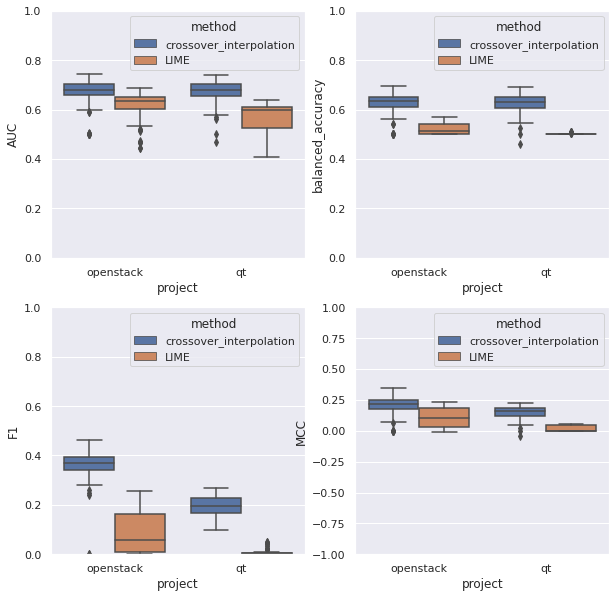

In [895]:
openstack_result_df = pd.read_csv('./eval_result/RQ555_openstack_test_commit_prediction_by_local_model_lime_decile_20_rules.csv')
qt_result_df = pd.read_csv('./eval_result/RQ555_qt_test_commit_prediction_by_local_model_lime_decile_20_rules.csv')

result_df = pd.concat([openstack_result_df, qt_result_df])
display(result_df.head())

fig, axs = plt.subplots(2,2, figsize=(10,10))

axs[0,0].set(ylim=(0, 1))
axs[0,1].set(ylim=(0, 1))
axs[1,0].set(ylim=(0, 1))
axs[1,1].set(ylim=(-1, 1))

sns.boxplot(data=result_df, x='project', y='AUC', hue='method', ax=axs[0,0])
sns.boxplot(data=result_df, x='project', y='balanced_accuracy', hue='method', ax=axs[0,1])
sns.boxplot(data=result_df, x='project', y='F1', hue='method', ax=axs[1,0])

sns.boxplot(data=result_df, x='project', y='MCC', hue='method', ax=axs[1,1])

plt.show()

openstack
finished 1 from 198 commits
finished 2 from 198 commits
finished 3 from 198 commits
finished 4 from 198 commits
finished 5 from 198 commits
finished 6 from 198 commits
finished 7 from 198 commits
finished 8 from 198 commits
finished 9 from 198 commits
finished 10 from 198 commits
finished 11 from 198 commits
finished 12 from 198 commits
finished 13 from 198 commits
finished 14 from 198 commits
finished 15 from 198 commits
finished 16 from 198 commits
finished 17 from 198 commits
finished 18 from 198 commits
finished 19 from 198 commits
finished 20 from 198 commits
finished 21 from 198 commits
finished 22 from 198 commits
finished 23 from 198 commits
finished 24 from 198 commits
finished 25 from 198 commits
finished 26 from 198 commits
finished 27 from 198 commits
finished 28 from 198 commits
finished 29 from 198 commits
finished 30 from 198 commits
finished 31 from 198 commits
finished 32 from 198 commits
finished 33 from 198 commits
finished 34 from 198 commits
finished 35 f

rule_ratio                                   \
                                       count       mean        std        min   
project   method                                                                
openstack LIME                         198.0  92.483019   2.027977  75.000000   
          crossover_interpolation      198.0  86.384273  29.451546   0.000000   
qt        LIME                          79.0  93.686244   0.852829  90.854326   
          crossover_interpolation       79.0  70.121895  42.744182   0.000000   

                                                                                
                                         25%        50%        75%         max  
project   method                                                                
openstack LIME                     91.969490  92.602913  93.031649   96.445498  
          crossover_interpolation  93.714503  96.946387  98.910973  100.000000  
qt        LIME                     93.346105  94.027618  94.396795   94.420926  
          crossover_interpolation   0.000000  96.144279  97.507483  100.000000

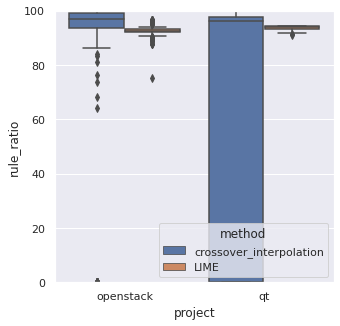

In [891]:
openstack_result_df = pd.read_csv('./eval_result/RQ3_555_openstack_lime_decile_20_rules.csv')
qt_result_df = pd.read_csv('./eval_result/RQ3_555_qt_lime_decile_20_rules.csv')

result_df = pd.concat([openstack_result_df, qt_result_df])
# display(result_df.head(10))

plt.ylim(0,100)
sns.boxplot(data=result_df, x='project', y='rule_ratio', hue='method')

display(result_df.groupby(['project','method']).describe())

,project,commit id,method,rule_ratio
0,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,crossover_interpolation,95.309883
1,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,LIME,91.950018
2,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,LIME,91.950018
3,openstack,de31210c05f464c4a79255de68b1a515d9b84ed3,LIME,90.744298
4,openstack,957533f685caf9ffc0d9cad569598455d59ade34,crossover_interpolation,94.690265
5,openstack,957533f685caf9ffc0d9cad569598455d59ade34,LIME,90.744298
6,openstack,96677735f6d8f1f5b6380127956921f719aab799,LIME,91.950018
7,openstack,10593c2eaf4eff4edb13b70f023acbbf743f129f,crossover_interpolation,100.000000
8,openstack,10593c2eaf4eff4edb13b70f023acbbf743f129f,LIME,91.950018
9,openstack,8db51da1e25f1c148fbe8d8f27d144a39d1850f3,crossover_interpolation,98.148148


rule_ratio                                   \
                                       count       mean        std        min   
project   method                                                                
openstack LIME                         198.0  91.253228   0.760854  89.389245   
          crossover_interpolation      138.0  88.200678  28.638557   0.000000   
qt        LIME                          38.0  93.440730   1.069584  91.503409   
          crossover_interpolation       39.0  84.670515  32.938067   0.000000   

                                                                                
                                         25%        50%        75%         max  
project   method                                                                
openstack LIME                     90.744298  91.950018  91.950018   91.950018  
          crossover_interpolation  94.742189  97.391107  99.565644  100.000000  
qt        LIME                     94.027618  94.027618  94.027618   94.027618  
          crossover_interpolation  95.695977  96.645367  98.282784  100.000000

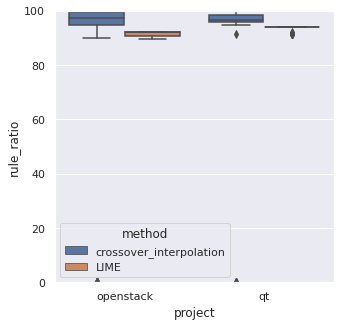

In [882]:
openstack_result_df = pd.read_csv('./eval_result/RQ3_555_openstack_lime_decile_20_rules_new.csv')
qt_result_df = pd.read_csv('./eval_result/RQ3_555_qt_lime_decile_20_rules_new.csv')

result_df = pd.concat([openstack_result_df, qt_result_df])
display(result_df.head(10))

plt.ylim(0,100)
sns.boxplot(data=result_df, x='project', y='rule_ratio', hue='method')

display(result_df.groupby(['project','method']).describe())

,project,commit id,method,rule_ratio
0,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,crossover_interpolation,95.000000
1,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,LIME,87.343702
2,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,crossover_interpolation,97.732997
3,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,LIME,88.146482
4,openstack,de31210c05f464c4a79255de68b1a515d9b84ed3,crossover_interpolation,80.516432
5,openstack,de31210c05f464c4a79255de68b1a515d9b84ed3,LIME,85.401662
6,openstack,957533f685caf9ffc0d9cad569598455d59ade34,crossover_interpolation,86.666667
7,openstack,957533f685caf9ffc0d9cad569598455d59ade34,LIME,91.477273
8,openstack,96677735f6d8f1f5b6380127956921f719aab799,crossover_interpolation,0.000000
9,openstack,96677735f6d8f1f5b6380127956921f719aab799,LIME,88.730929


rule_ratio                                   \
                                       count       mean        std        min   
project   method                                                                
openstack LIME                         198.0  90.274851   3.170842  84.613229   
          crossover_interpolation      198.0  82.980207  30.230322   0.000000   
qt        LIME                          79.0  95.426392   0.766852  93.037861   
          crossover_interpolation       79.0  71.452577  43.431308   0.000000   

                                                                                
                                         25%        50%        75%         max  
project   method                                                                
openstack LIME                     88.146482  88.923720  92.771084  100.000000  
          crossover_interpolation  87.686758  94.297329  98.075397  100.000000  
qt        LIME                     94.854693  95.661320  95.960179   98.421808  
          crossover_interpolation   0.000000  98.148148  98.984745  100.000000

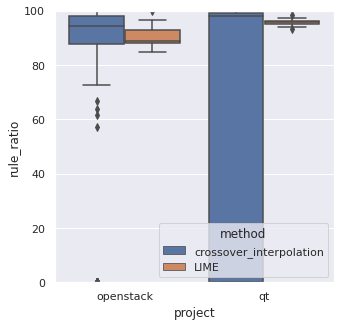

In [892]:
openstack_result_df = pd.read_csv('./eval_result/RQ4_555_openstack_lime_decile_20_rules.csv')
qt_result_df = pd.read_csv('./eval_result/RQ4_555_qt_lime_decile_20_rules.csv')

result_df = pd.concat([openstack_result_df, qt_result_df])
display(result_df.head(10))

plt.ylim(0,100)
sns.boxplot(data=result_df, x='project', y='rule_ratio', hue='method')

display(result_df.groupby(['project','method']).describe())

,project,commit id,method,rule_ratio
0,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,crossover_interpolation,95.000000
1,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,LIME,86.683347
2,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,LIME,86.683347
3,openstack,de31210c05f464c4a79255de68b1a515d9b84ed3,LIME,85.401662
4,openstack,957533f685caf9ffc0d9cad569598455d59ade34,crossover_interpolation,86.666667
5,openstack,957533f685caf9ffc0d9cad569598455d59ade34,LIME,85.401662
6,openstack,96677735f6d8f1f5b6380127956921f719aab799,LIME,86.683347
7,openstack,10593c2eaf4eff4edb13b70f023acbbf743f129f,crossover_interpolation,100.000000
8,openstack,10593c2eaf4eff4edb13b70f023acbbf743f129f,LIME,86.683347
9,openstack,8db51da1e25f1c148fbe8d8f27d144a39d1850f3,crossover_interpolation,89.285714


rule_ratio                                   \
                                       count       mean        std        min   
project   method                                                                
openstack LIME                         198.0  86.071260   1.021572  83.655084   
          crossover_interpolation      138.0  84.656934  30.026178   0.000000   
qt        LIME                          38.0  95.075636   1.085954  93.037861   
          crossover_interpolation       39.0  85.510896  33.344035   0.000000   

                                                                     \
                                         25%        50%         75%   
project   method                                                      
openstack LIME                     85.401662  86.683347   86.683347   
          crossover_interpolation  89.741379  94.982639  100.000000   
qt        LIME                     95.661320  95.661320   95.661320   
          crossover_interpolation  97.371559  98.442368   99.276609   

                                               
                                          max  
project   method                               
openstack LIME                      90.990991  
          crossover_interpolation  100.000000  
qt        LIME                      95.661320  
          crossover_interpolation  100.000000

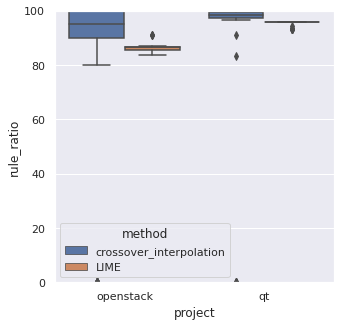

In [883]:
openstack_result_df = pd.read_csv('./eval_result/RQ4_openstack_lime_decile_20_rules_new.csv')
qt_result_df = pd.read_csv('./eval_result/RQ4_qt_lime_decile_20_rules_new.csv')

result_df = pd.concat([openstack_result_df, qt_result_df])
display(result_df.head(10))

plt.ylim(0,100)
sns.boxplot(data=result_df, x='project', y='rule_ratio', hue='method')

display(result_df.groupby(['project','method']).describe())

finished RQ1 of openstack
finished RQ1 of qt


,project,commit id,method,euc_dist_med,defective_generated_instance_ratio
0,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,crossover_interpolation,354.738406,0.406250
1,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,LIME,479.405778,0.003600
2,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,crossover_interpolation,494.990758,0.770257
3,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,LIME,1322.151611,0.008600
4,openstack,de31210c05f464c4a79255de68b1a515d9b84ed3,crossover_interpolation,232.856076,0.566071


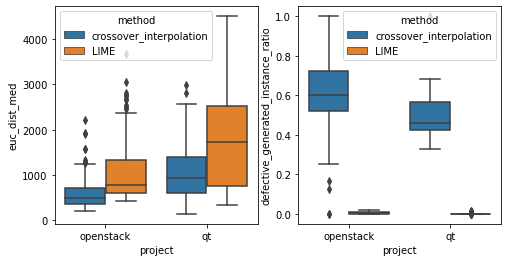

openstack result


euc_dist_med                                       \
                               count         mean         std         min   
method                                                                      
LIME                           198.0  1061.468282  633.440499  418.108698   
crossover_interpolation        198.0   592.369333  336.972263  211.235688   

                                                                           \
                                25%         50%          75%          max   
method                                                                      
LIME                     602.797922  788.432944  1337.689842  3679.497205   
crossover_interpolation  360.263004  494.947457   717.450402  2219.862411   

                        defective_generated_instance_ratio            \
                                                     count      mean   
method                                                                 
LIME                                                 198.0  0.004772   
crossover_interpolation                              198.0  0.610123   

                                                                              
                              std  min       25%       50%       75%     max  
method                                                                        
LIME                     0.004454  0.0  0.000600  0.004000  0.008550  0.0178  
crossover_interpolation  0.152132  0.0  0.519085  0.603223  0.724593  1.0000

qt result


euc_dist_med                                        \
                               count         mean          std         min   
method                                                                       
LIME                            79.0  1782.554741  1104.872167  328.933327   
crossover_interpolation         79.0  1075.365549   664.703661  140.597045   

                                                                            \
                                25%          50%          75%          max   
method                                                                       
LIME                     767.305166  1723.787418  2524.461375  4505.040648   
crossover_interpolation  599.290091   931.887346  1390.417825  2980.305885   

                        defective_generated_instance_ratio            \
                                                     count      mean   
method                                                                 
LIME                                                  79.0  0.001344   
crossover_interpolation                               79.0  0.494272   

                                                                         \
                              std       min       25%     50%       75%   
method                                                                    
LIME                     0.003419  0.000000  0.000000  0.0002  0.000200   
crossover_interpolation  0.104604  0.329301  0.423437  0.4614  0.566768   

                                 
                            max  
method                           
LIME                     0.0138  
crossover_interpolation  1.0000